In [16]:
## Gate sweep curves

In [17]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from IPython.display import display
import sys
from statistics import mean
from timeit import default_timer as timer
from matplotlib.mlab import frange
from numpy import sqrt
from myheatmap import myheatmap

# * Windows versus mac.
#folder = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/08/09/'
#folder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\08\09' 
folder = r'C:\Users\vhorowit\Desktop\tempdata'

## Detect peaks function
## http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
# You can copy the function from there and save it to your computer.
sys.path.append(r'C:\Users\vhorowit\Documents')
#sys.path.append(r'/Users/brittanycarter/Python Code/')
import detect_peaks
from detect_peaks import detect_peaks

#sns.set(style='ticks') # makes longer tick marks
sns.set_context('poster') # makes text larger

## Fitting functions
def lowerantifn(x,m1,m2,k,k1):
    k2 = k1+x;
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1 - 
                      sqrt(-4*(k*k1 + k*k2 + k1*k2)*m1*m2 + (-k*m1 - k2*m1 - k*m2 - k1*m2)**2)
                      /(m1*m2))/sqrt(2)
def upperantifn(x,m1,m2,k,k1):
    k2 = k1+x;
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1 + 
                      sqrt(-4*(k*k1 + k*k2 + k1*k2)*m1*m2 + (-k*m1 - k2*m1 - k*m2 - k1*m2)**2)
                      /(m1*m2))/sqrt(2)
def middle1(x, m1,m2,k,k1):
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1)/sqrt(2)

def W(x,A,B,C,D,sigma0, offset=0):
    x = x - offset; # Center does not have to be at zero.
    # Recursive definition of sigma: sigma == sigma0 + D*x**4/sigma^2.
    sigma = (sigma0 + (2**(1/3)*sigma0**2)/(2*sigma0**3 + 27*D*x**4 + 3*sqrt(3)*sqrt(4*D*sigma0**3*x**4 + 27*D**2*x**8))**(1/3) 
             + (2*sigma0**3 + 27*D*x**4 + 3*sqrt(3)*sqrt(4*D*sigma0**3*x**4 + 27*D**2*x**8))**(1/3)/2**(1/3))/3
    W = sqrt(A - B*x**2 + C*x**4/sigma)
    return W

def Wresidual(params, x, data):
    A = params['A']
    B = params['B']
    C = params['C']
    D = params['D']
    sigma0 = params['sigma0']
    offset = params['offset']

    model = W(x,A,B,C,D,sigma0, offset)
    resid = data - model
    return resid
    
def anticrossingresidual(params, x, upperdat, lowerdat):
    m1 = params['m1']
    m2 = params['m2']
    k = params['k'] # coupling spring
    k1 = params['k1']

    model1 = upperantifn(x, m1,m2,k,k1)
    model2 = lowerantifn(x, m1,m2,k,k1)
    
    resid1 = upperdat - model1
    resid2 = lowerdat - model2
    return np.concatenate((resid1, resid2))

def offsetindex(df, offset, indexname):
    dfoffset = df.copy()
    dfoffset.index = df.index- offset
    dfoffset.index.name = indexname
    return dfoffset

import lmfit
print(lmfit.__version__)

0.9.14


C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


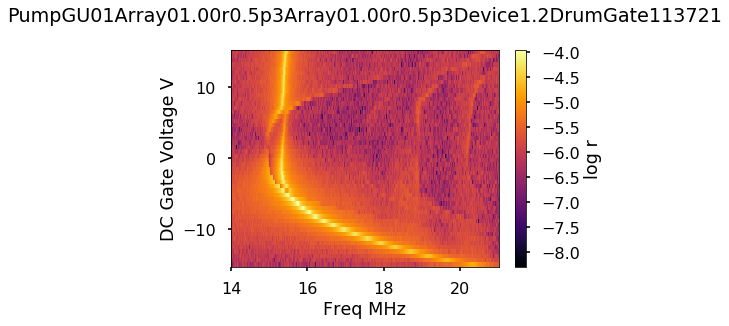

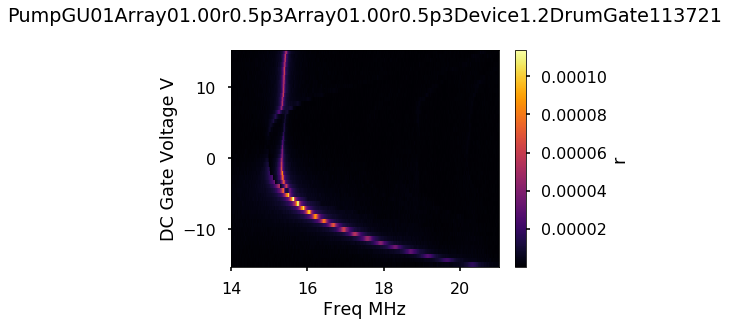

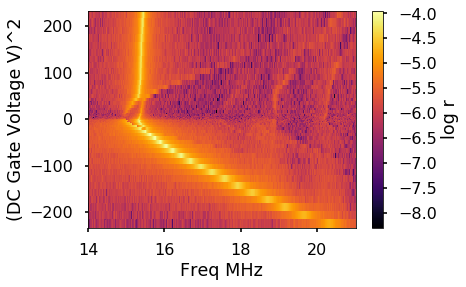

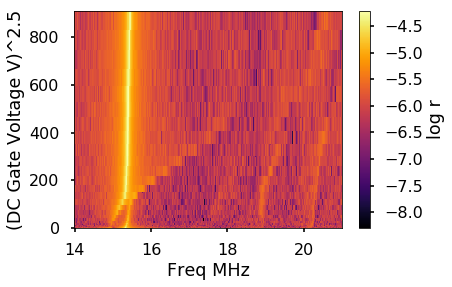

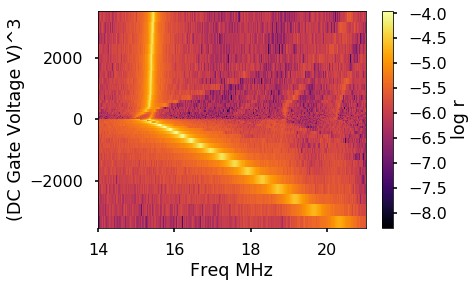

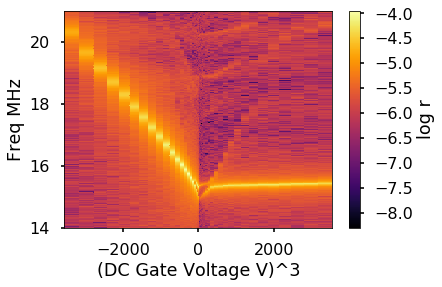

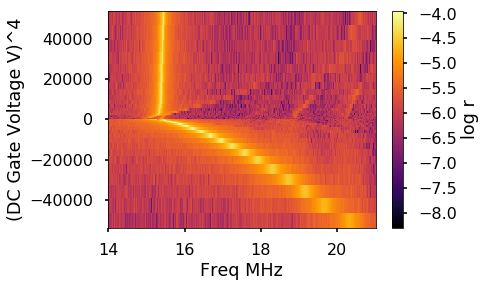

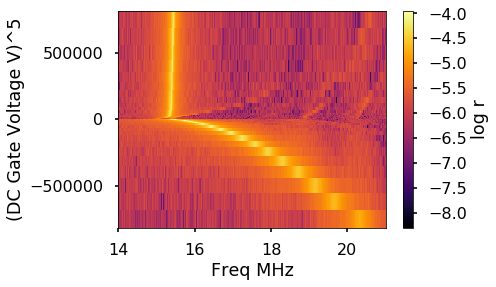

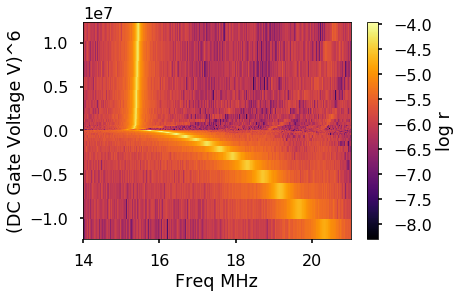

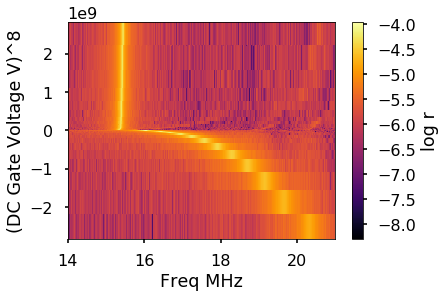

In [18]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)  

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(9)

p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
#sns.heatmap(p)

"""
Vpowplot plots the voltage and frequency data after calculating the voltage to the power n.
"""
def Vpowplot(df,n, transpose =False, cmap = 'inferno', offset=0, **kwargs):
    if (-1)**n == -1:
        df['(DC Gate Voltage V)^' + str(n)] = ((df['Keithley Voltage'])**n).round(9)
        nthlog = df.pivot_table(index = '(DC Gate Voltage V)^' + str(n), columns = 'Freq MHz', 
                            values = 'rlog').sort_index(axis = 0, ascending = False) 
    else:
        ## Need to explicitly separate positive and negative voltages.
        posdf = df[df['Keithley Voltage']>0]
        negdf = df[df['Keithley Voltage']<0]
        posdf['(DC Gate Voltage V)^' + str(n)] = ((posdf['Keithley Voltage'])**n).round(9)
        negdf['(DC Gate Voltage V)^' + str(n)] = -((negdf['Keithley Voltage'])**n).round(9)
        posnthlog = posdf.pivot_table(index = '(DC Gate Voltage V)^' + str(n), columns = 'Freq MHz', 
                            values = 'rlog').sort_index(axis = 0, ascending = False) 
        negnthlog = negdf.pivot_table(index = '(DC Gate Voltage V)^' + str(n), columns = 'Freq MHz', 
                            values = 'rlog').sort_index(axis = 0, ascending = False) 
        nthlog = pd.concat([posnthlog,negnthlog])
    if offset:
        nthlog = offsetindex(nthlog, offset, '(Voltage diff)^' + str(n))
    plt.figure()
    if transpose:
        myheatmap(nthlog.transpose(), 'log r', cmap = cmap, **kwargs)
    else:
        myheatmap(nthlog, 'log r', cmap = cmap, **kwargs)


plt.figure()
myheatmap(p,'log r', cmap = 'inferno')
plt.title(file + '\n');

# This is the same heatmap as shown above except it shows r instead of log(r)

plt.figure()
p2 = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(p2, 'r', cmap='inferno')
plt.title(file + '\n');

Vpowplot(df, 2)
Vpowplot(df, 2.5)
Vpowplot(df, 3)
Vpowplot(df, 3, transpose=True)

Vpowplot(df, 4)
Vpowplot(df, 5)
Vpowplot(df, 6)
Vpowplot(df, 8)

14

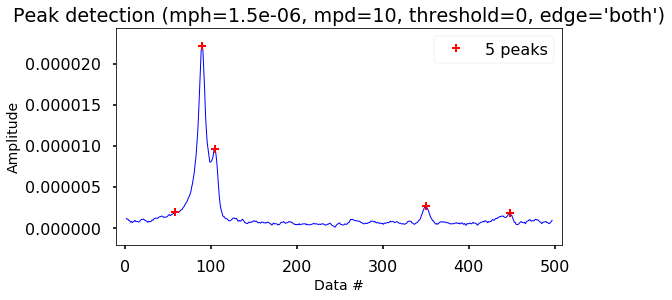

[58, 90, 105, 350, 448]


In [19]:
i = 14
if True:
    data = p2.iloc[i]
    display(i)
    ## Manual adjustement
    if True:
        mph = 1.5e-6;
        #print(mph)
        mpd = 10
    if True:
        window = 5;
    res = detect_peaks(pd.DataFrame.rolling(data, window, center=True).sum()/window, 
             mph=mph, 
             #threshold=1e-9,
             mpd=mpd,
             edge = 'both',
             show=True)
    #print(res)
    if True:
        res = list(res)
    print(res)

In [20]:
p2.head()

Freq MHz              14.000000     14.014028     14.028056     14.042084  \
DC Gate Voltage V                                                           
14.99958           4.650000e-07  1.022000e-06  1.157000e-06  6.710000e-07   
14.38771           5.700000e-07  7.740000e-07  1.098000e-06  4.440000e-07   
13.77534           7.800000e-07  1.136000e-06  5.510000e-07  9.540000e-07   
13.16336           8.770000e-07  8.870000e-07  1.060000e-06  1.150000e-06   
12.55072           6.820000e-07  7.360000e-07  8.670000e-07  4.440000e-07   

Freq MHz              14.056112     14.070140     14.084168     14.098196  \
DC Gate Voltage V                                                           
14.99958           8.100000e-07  1.027000e-06  1.528000e-06  1.115000e-06   
14.38771           1.063000e-06  9.850000e-07  5.330000e-07  1.130000e-06   
13.77534           5.010000e-07  5.810000e-07  7.640000e-07  5.280000e-07   
13.16336           1.309000e-06  9.910000e-07  1.076000e-06  1.338000e-06   
12.55072           9.340000e-07  7.660000e-07  9.020000e-07  7.510000e-07   

Freq MHz              14.112224     14.126253      ...          20.873747  \
DC Gate Voltage V                                  ...                      
14.99958           9.200000e-07  7.840000e-07      ...       8.050000e-07   
14.38771           7.720000e-07  1.641000e-06      ...       1.102000e-06   
13.77534           1.016000e-06  8.760000e-07      ...       3.380000e-07   
13.16336           8.440000e-07  9.310000e-07      ...       7.640000e-07   
12.55072           1.078000e-06  9.830000e-07      ...       1.617000e-06   

Freq MHz              20.887776     20.901804     20.915832     20.929860  \
DC Gate Voltage V                                                           
14.99958           6.350000e-07  1.033000e-06  9.840000e-07  4.960000e-07   
14.38771           9.950000e-07  1.420000e-06  8.810000e-07  2.260000e-07   
13.77534           7.100000e-08  1.118000e-06  3.300000e-07  2.670000e-07   
13.16336           8.120000e-07  8.960000e-07  1.192000e-06  7.870000e-07   
12.55072           1.526000e-06  1.678000e-06  1.618000e-06  2.074000e-06   

Freq MHz              20.943888     20.957916     20.971944     20.985972  \
DC Gate Voltage V                                                           
14.99958           9.800000e-07  1.571000e-06  1.095000e-06  7.400000e-07   
14.38771           7.940000e-07  4.410000e-07  2.270000e-07  8.510000e-07   
13.77534           5.310000e-07  3.170000e-07  1.880000e-07  3.110000e-07   
13.16336           7.910000e-07  3.900000e-07  9.560000e-07  9.480000e-07   
12.55072           1.415000e-06  9.640000e-07  1.629000e-06  1.233000e-06   

Freq MHz              21.000000  
DC Gate Voltage V                
14.99958           9.830000e-07  
14.38771           2.770000e-07  
13.77534           1.056000e-06  
13.16336           1.260000e-06  
12.55072           1.247000e-06  

[5 rows x 500 columns]

In [21]:
p2.index[0]

14.99958

17.507014028 MHz


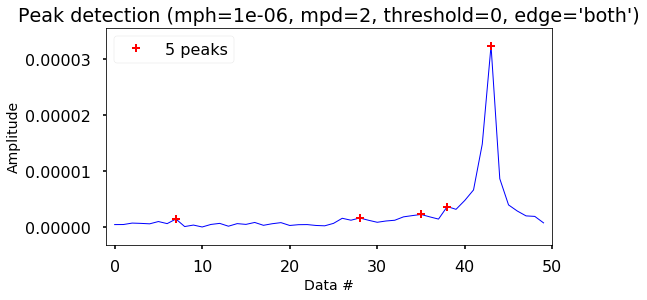

[ 7 28 35 38 43]


In [22]:
voltslist = []
voltpeakints = []

i = 250
window = 1
mph = 1e-6
mpd = 2
#p2.iloc[:,i].plot()

if True:
#for i in range(len(p2.columns)):
    data = p2.iloc[:,i]
    print(str(data.name) + " MHz")
    res = detect_peaks(pd.DataFrame.rolling(data, window, center=True).sum()/window, 
             mph=mph, 
             #threshold=1e-7,
             mpd=mpd,
             edge = 'both',
             show=True)
    print(res)
    res = list(res)
    voltpeakints.append(res[:])
    voltslist.append(p2.index[res[:]])



In [23]:
"""peakfreqsp3 = pd.DataFrame(voltslist, index = p2.columns,)# columns = p2.columns)#, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])

#pfsp3 = peakfreqsp3.loc[15.5:18.1]
#display(pfsp3.head())

peakfreqsp3.plot(marker='.', color='k', alpha=0.2, linestyle=None, linewidth=0, legend=False)
myheatmap(p,'log r', cmap = 'inferno')
plt.title(file + '\n');
""";

0

Gate voltage: 14.99958 V


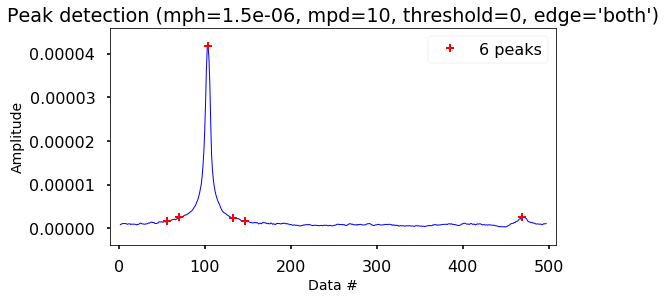

[104, 469]


1

Gate voltage: 14.38771 V


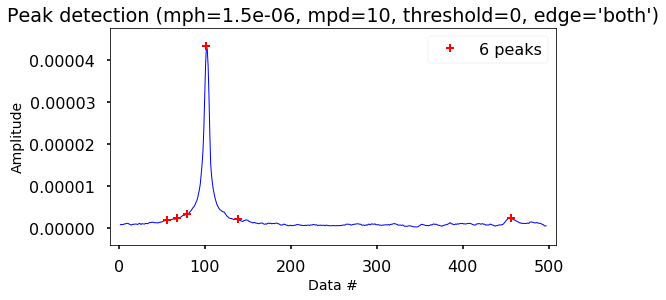

[102, 456]


2

Gate voltage: 13.77534 V


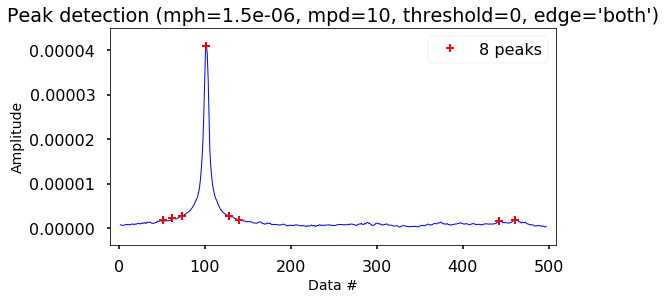

[102, 442, 461]


3

Gate voltage: 13.16336 V


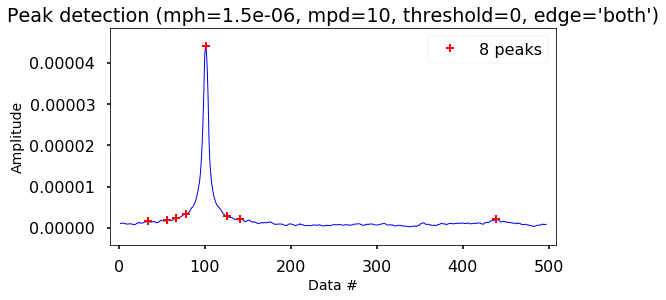

[101, 439]


4

Gate voltage: 12.55072 V


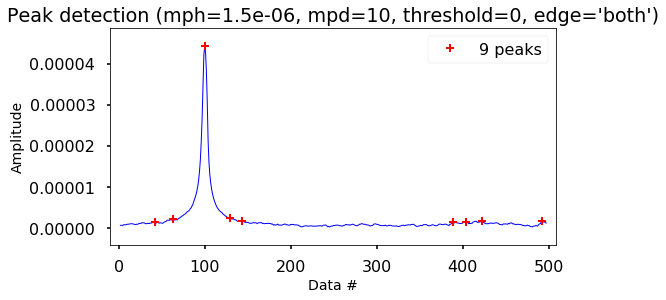

[100]


5

Gate voltage: 11.93879 V


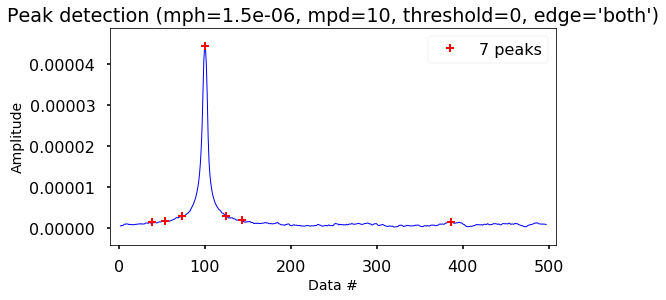

[100, 386]


6

Gate voltage: 11.32653 V


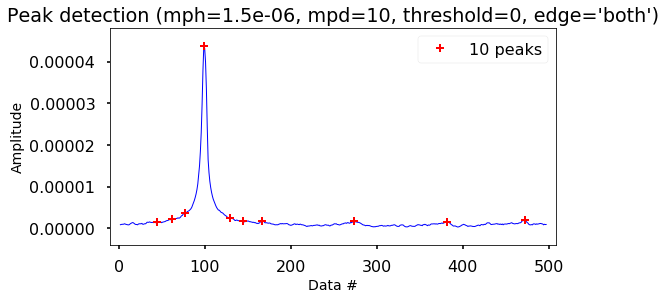

[99, 274, 382, 472]


7

Gate voltage: 10.71422 V


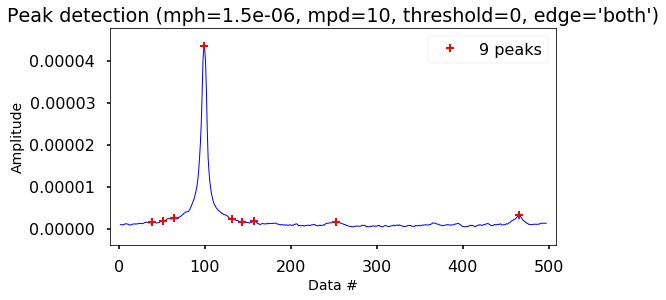

[99, 253, 466]


8

Gate voltage: 10.102 V


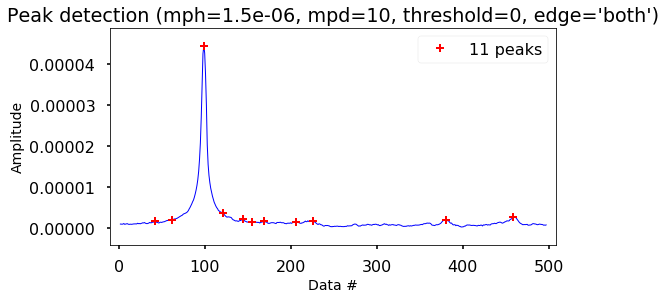

[99, 226, 380, 459]


9

Gate voltage: 9.489918 V


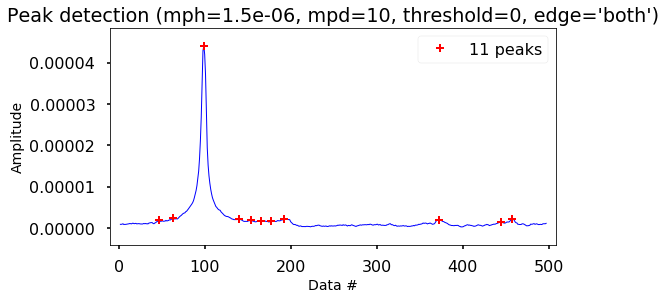

[99, 192, 372, 457]


10

Gate voltage: 8.877301 V


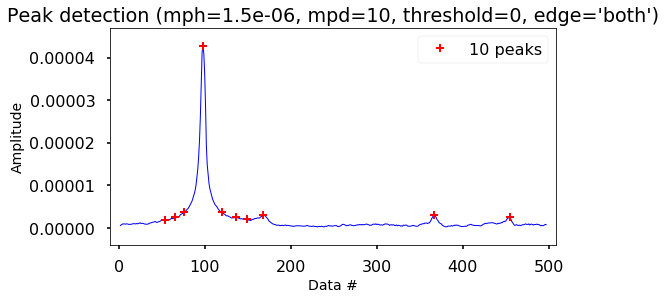

[98, 168, 367, 455]


11

Gate voltage: 8.265319 V


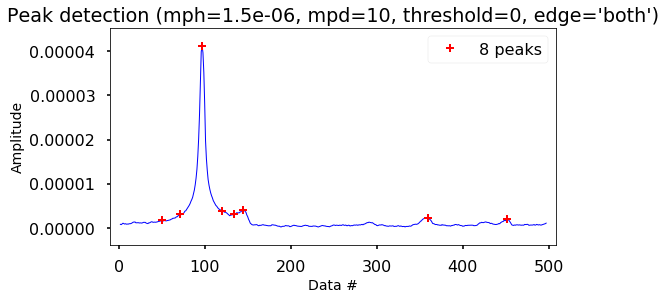

[97, 145, 360, 452]


12

Gate voltage: 7.653055 V


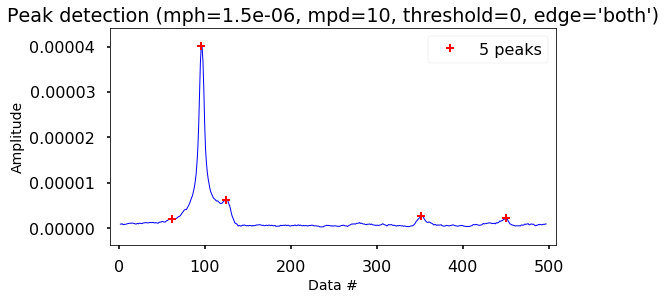

[96, 125, 352, 450]


13

Gate voltage: 7.041093 V


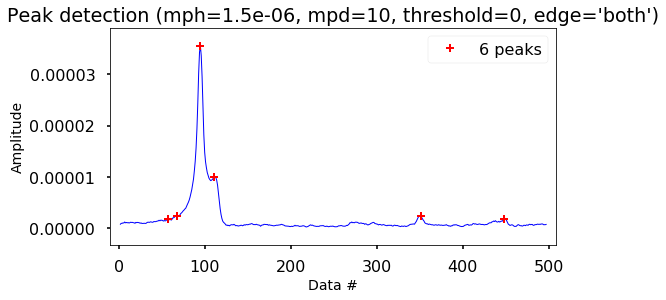

[95, 111, 351, 448]


14

Gate voltage: 6.42846 V


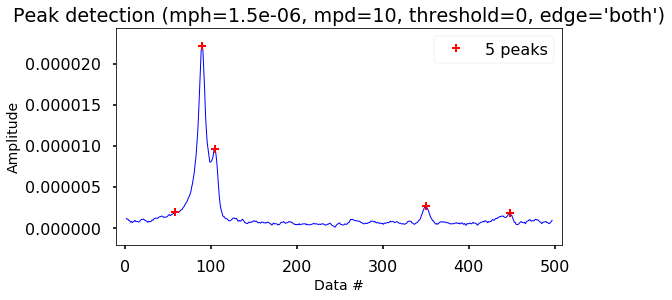

[90, 105, 350, 448]


15

Gate voltage: 5.816485 V


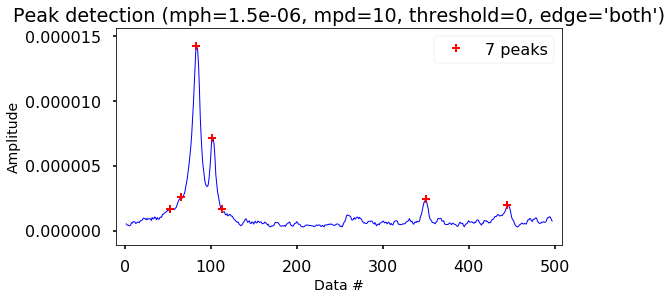

[83, 102, 350, 445]


16

Gate voltage: 5.204129 V


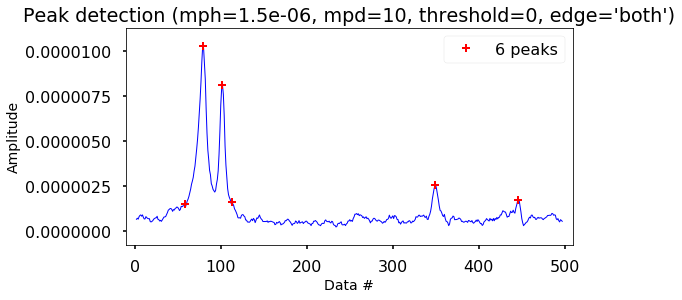

[79, 102, 349, 446]


17

Gate voltage: 4.592117 V


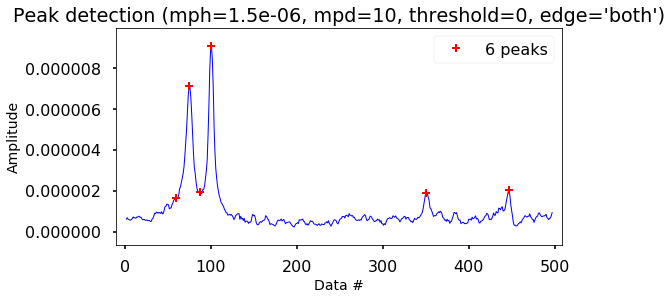

[75, 101, 350, 447]


18

Gate voltage: 3.979488 V


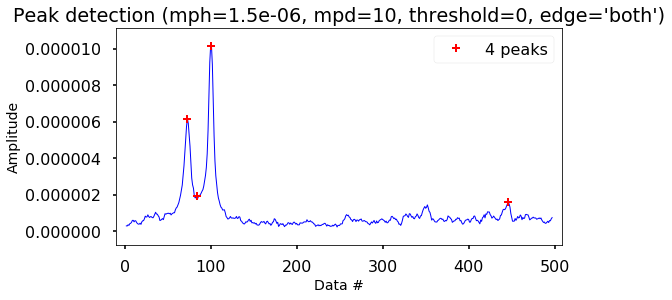

[73, 100, 446]


19

Gate voltage: 3.367526 V


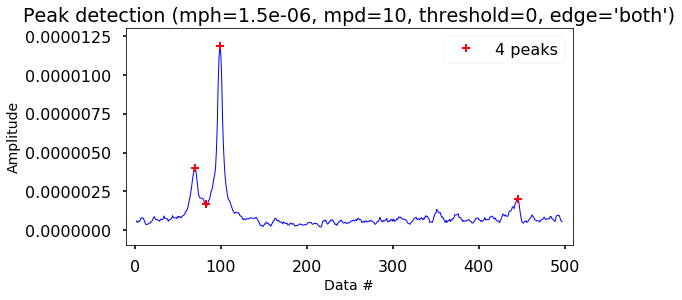

[70, 99, 445]


20

Gate voltage: 2.755219 V


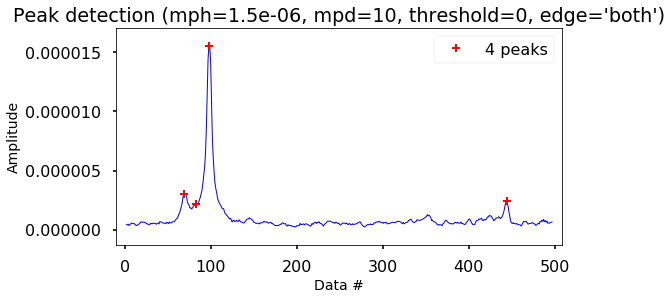

[69, 98, 444]


21

Gate voltage: 2.143201 V


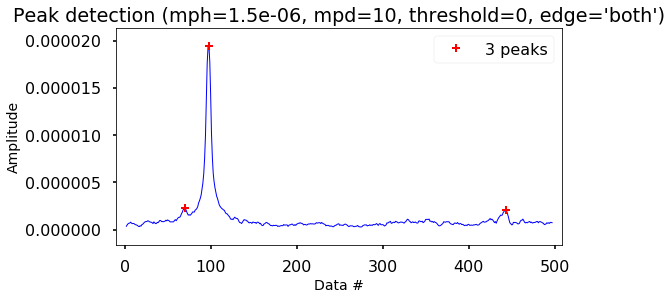

[70, 98, 443]


22

Gate voltage: 1.530562 V


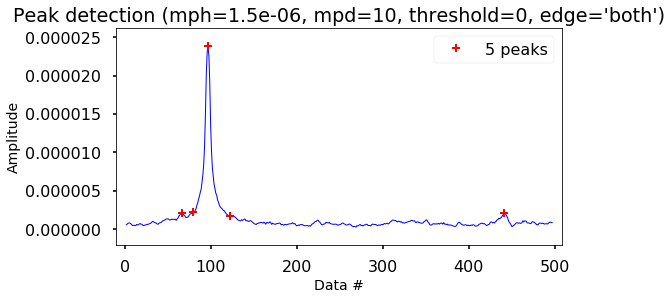

[67, 97, 441]


23

Gate voltage: 0.9183441 V


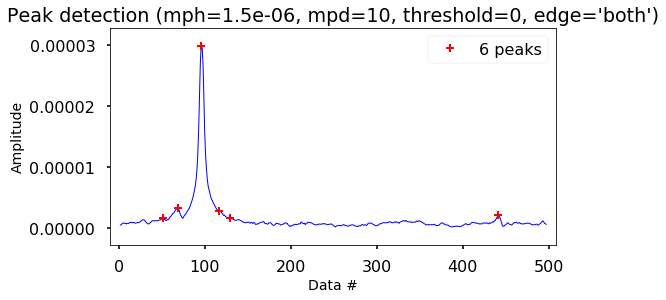

[69, 96, 441]


24

Gate voltage: 0.3061051 V


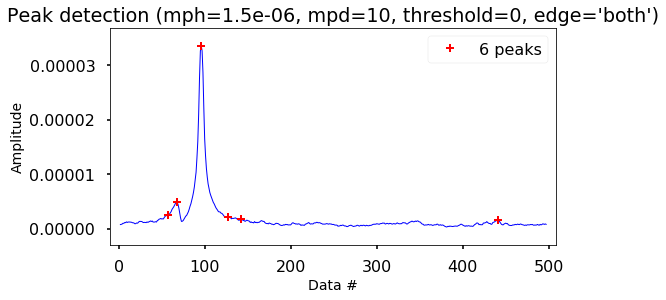

[68, 96, 441]


25

Gate voltage: -0.3060929 V


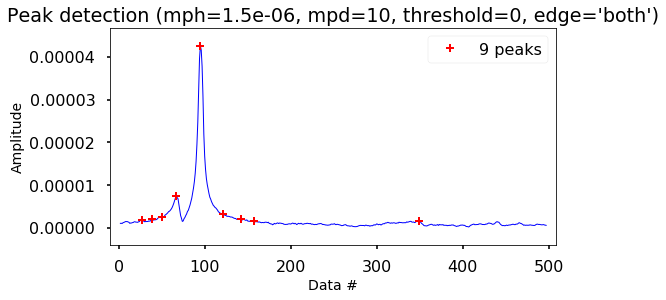

[67, 95, 349]


26

Gate voltage: -0.9183689 V


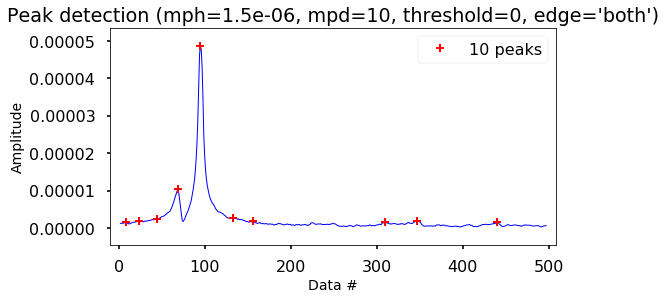

[69, 95, 347, 440]


27

Gate voltage: -1.530587 V


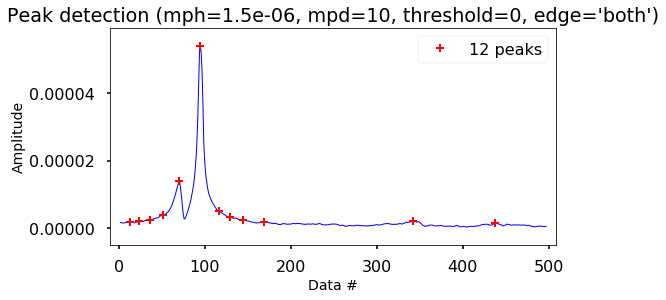

[70, 95, 342, 438]


28

Gate voltage: -2.142865 V


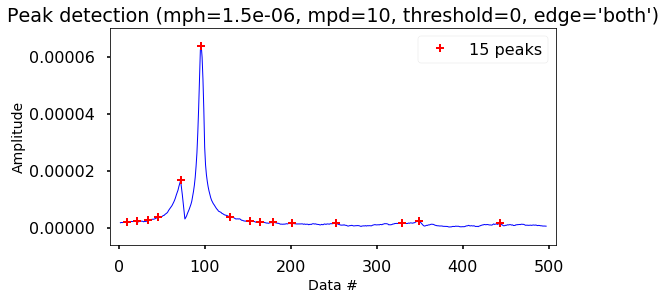

[72, 96, 349, 443]


29

Gate voltage: -2.75487 V


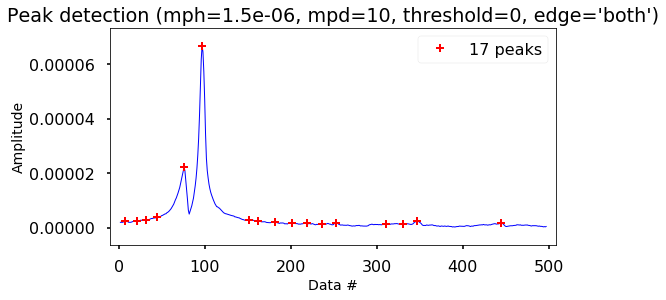

[76, 97, 347, 444]


30

Gate voltage: -3.367548 V


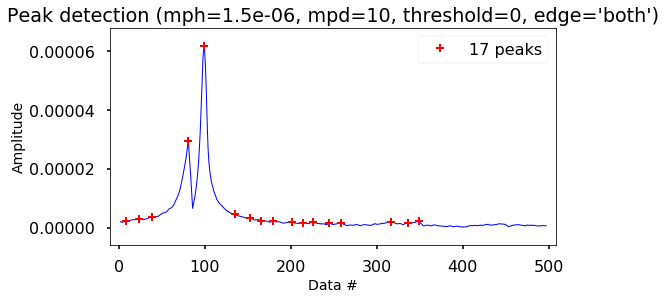

[81, 99, 349]


31

Gate voltage: -3.979493 V


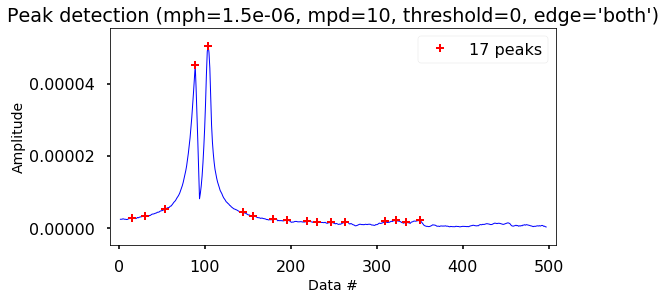

[89, 104, 350]


32

Gate voltage: -4.591816 V


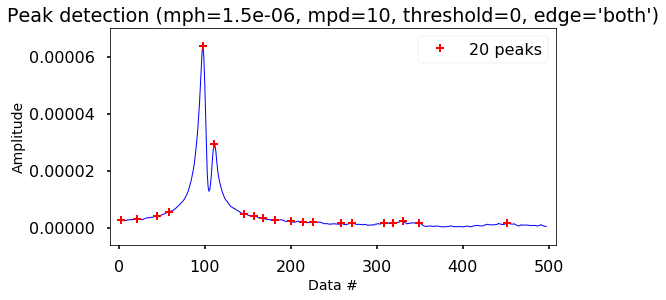

[98, 111, 451]


33

Gate voltage: -5.204167 V


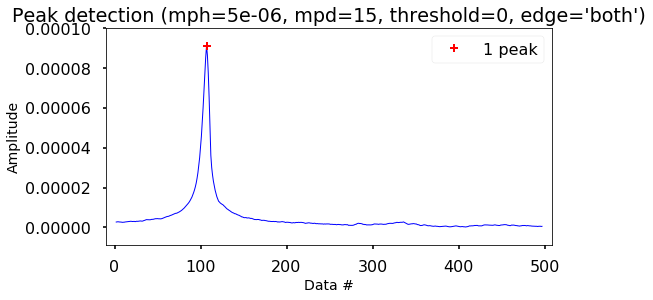

[107]


34

Gate voltage: -5.816509 V


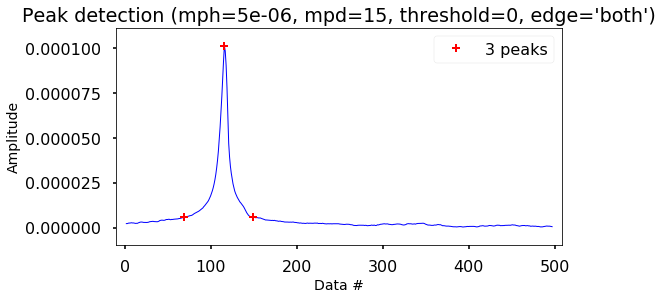

[116]


35

Gate voltage: -6.42851 V


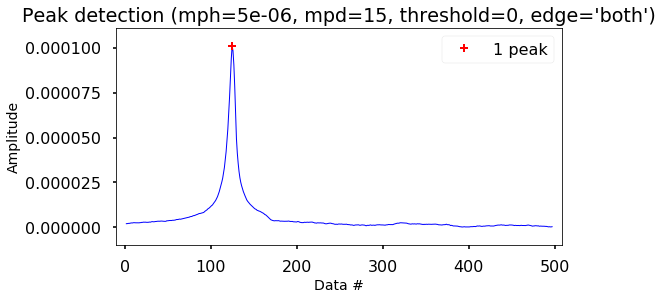

[125]


36

Gate voltage: -7.041137 V


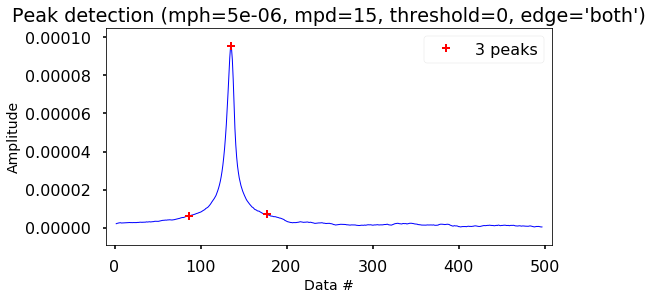

[135]


37

Gate voltage: -7.653137 V


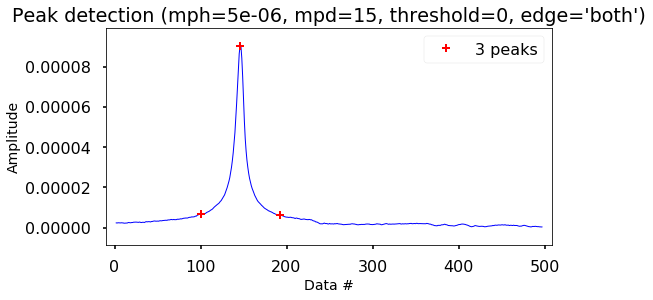

[146]


38

Gate voltage: -8.265352 V


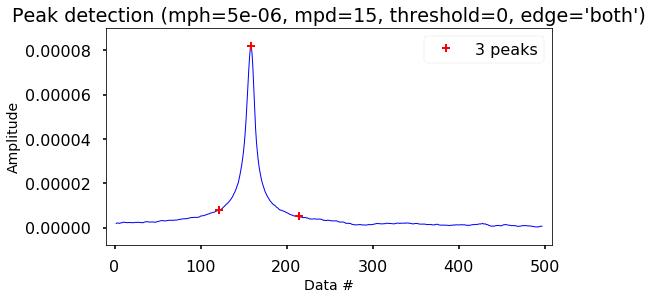

[159]


39

Gate voltage: -8.877698 V


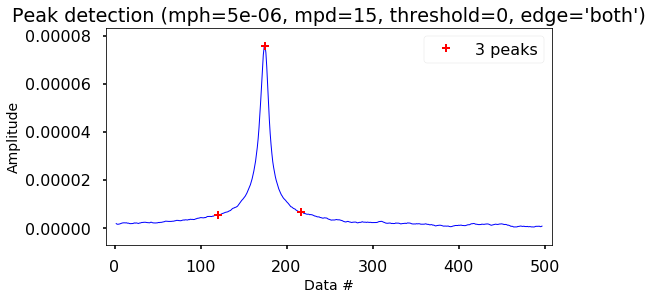

[175]


40

Gate voltage: -9.489979 V


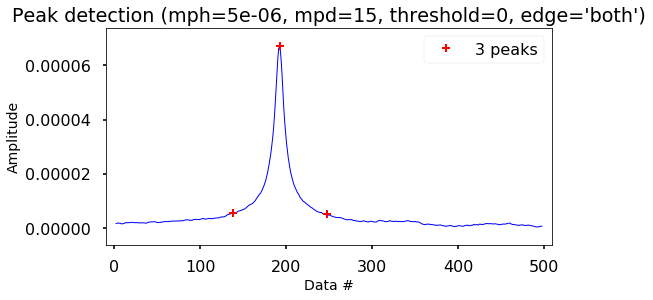

[192]


41

Gate voltage: -10.102 V


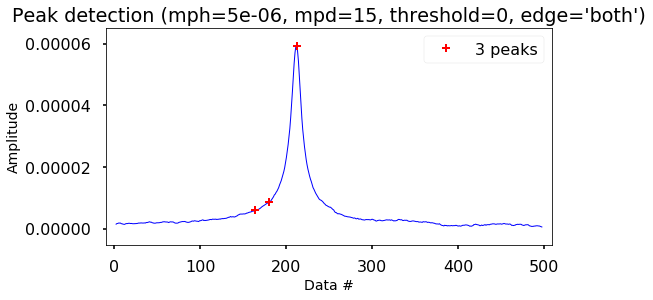

[212]


42

Gate voltage: -10.7146 V


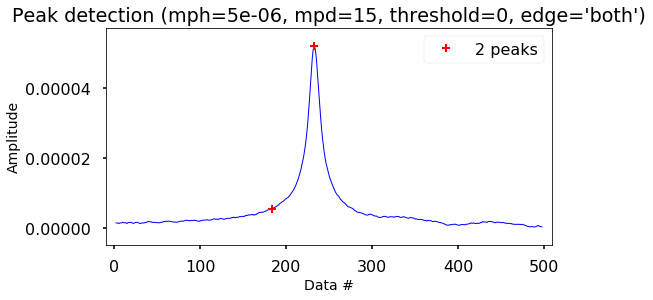

[232]


43

Gate voltage: -11.32659 V


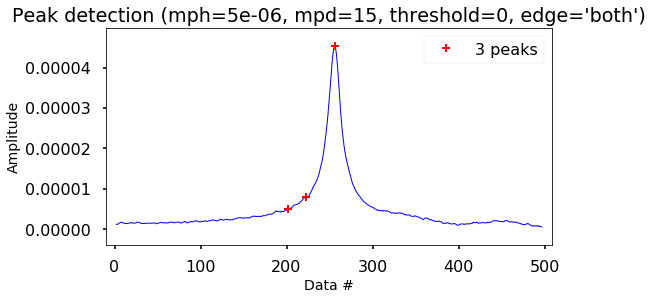

[256]


44

Gate voltage: -11.93891 V


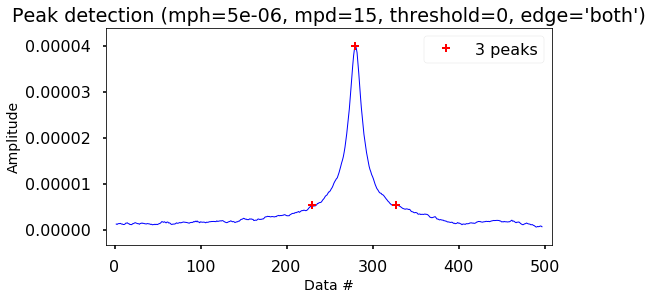

[280]


45

Gate voltage: -12.55081 V


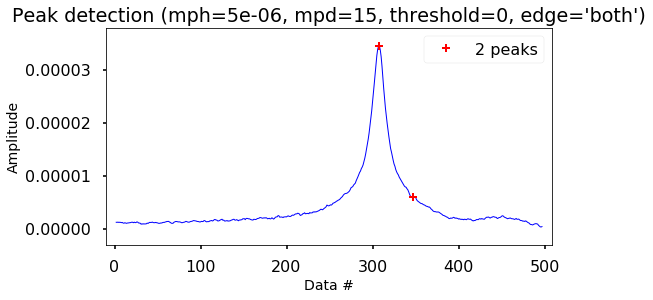

[308]


46

Gate voltage: -13.16347 V


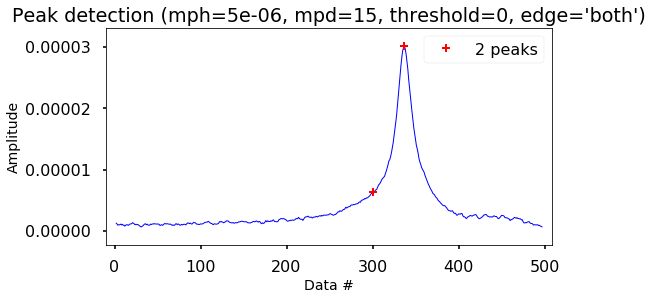

[337]


47

Gate voltage: -13.77543 V


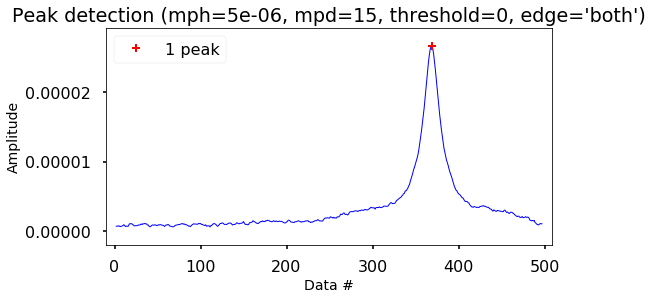

[369]


48

Gate voltage: -14.38811 V


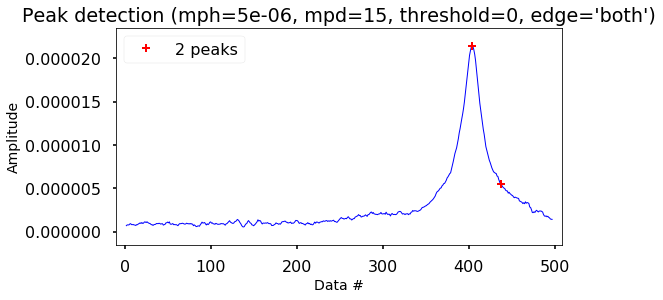

[404]


49

Gate voltage: -15.00003 V


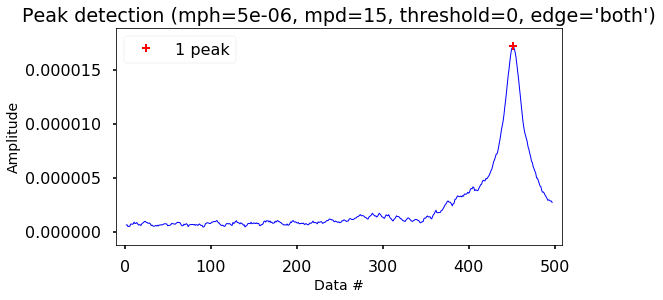

[452]


[[104, 469],
 [102, 456],
 [102, 442, 461],
 [101, 439],
 [100],
 [100, 386],
 [99, 274, 382, 472],
 [99, 253, 466],
 [99, 226, 380, 459],
 [99, 192, 372, 457],
 [98, 168, 367, 455],
 [97, 145, 360, 452],
 [96, 125, 352, 450],
 [95, 111, 351, 448],
 [90, 105, 350, 448],
 [83, 102, 350, 445],
 [79, 102, 349, 446],
 [75, 101, 350, 447],
 [73, 100, 446],
 [70, 99, 445],
 [69, 98, 444],
 [70, 98, 443],
 [67, 97, 441],
 [69, 96, 441],
 [68, 96, 441],
 [67, 95, 349],
 [69, 95, 347, 440],
 [70, 95, 342, 438],
 [72, 96, 349, 443],
 [76, 97, 347, 444],
 [81, 99, 349],
 [89, 104, 350],
 [98, 111, 451],
 [107],
 [116],
 [125],
 [135],
 [146],
 [159],
 [175],
 [192],
 [212],
 [232],
 [256],
 [280],
 [308],
 [337],
 [369],
 [404],
 [452]]

[Float64Index([15.458917836, 20.579158317], dtype='float64', name='Freq MHz'),
 Float64Index([15.430861723, 20.396793587], dtype='float64', name='Freq MHz'),
 Float64Index([15.430861723, 20.200400802, 20.466933868], dtype='float64', name='Freq MHz'),
 Float64Index([15.416833667, 20.158316633], dtype='float64', name='Freq MHz'),
 Float64Index([15.402805611], dtype='float64', name='Freq MHz'),
 Float64Index([15.402805611, 19.414829659], dtype='float64', name='Freq MHz'),
 Float64Index([15.388777555, 17.843687375, 19.358717435, 20.621242485], dtype='float64', name='Freq MHz'),
 Float64Index([15.388777555, 17.549098196, 20.537074148], dtype='float64', name='Freq MHz'),
 Float64Index([15.388777555, 17.170340681, 19.330661323, 20.438877756], dtype='float64', name='Freq MHz'),
 Float64Index([15.388777555, 16.693386774, 19.218436874, 20.410821643], dtype='float64', name='Freq MHz'),
 Float64Index([15.374749499, 16.356713427, 19.148296593, 20.382765531], dtype='float64', name='Freq MHz'),
 Floa

0          1          2          3
DC Gate Voltage V                                            
 14.999580         15.458918  20.579158        NaN        NaN
 14.387710         15.430862  20.396794        NaN        NaN
 13.775340         15.430862  20.200401  20.466934        NaN
 13.163360         15.416834  20.158317        NaN        NaN
 12.550720         15.402806        NaN        NaN        NaN
 11.938790         15.402806  19.414830        NaN        NaN
 11.326530         15.388778  17.843687  19.358717  20.621242
 10.714220         15.388778  17.549098  20.537074        NaN
 10.102000         15.388778  17.170341  19.330661  20.438878
 9.489918          15.388778  16.693387  19.218437  20.410822
 8.877301          15.374749  16.356713  19.148297  20.382766
 8.265319          15.360721  16.034068  19.050100  20.340681
 7.653055          15.346693  15.753507  18.937876  20.312625
 7.041093          15.332665  15.557114  18.923848  20.284569
 6.428460          15.262525  15.472946  18.909820  20.284569
 5.816485          15.164329  15.430862  18.909820  20.242485
 5.204129          15.108216  15.430862  18.895792  20.256513
 4.592117          15.052104  15.416834  18.909820  20.270541
 3.979488          15.024048  15.402806  20.256513        NaN
 3.367526          14.981964  15.388778  20.242485        NaN
 2.755219          14.967936  15.374749  20.228457        NaN
 2.143201          14.981964  15.374749  20.214429        NaN
 1.530562          14.939880  15.360721  20.186373        NaN
 0.918344          14.967936  15.346693  20.186373        NaN
 0.306105          14.953908  15.346693  20.186373        NaN
-0.306093          14.939880  15.332665  18.895792        NaN
-0.918369          14.967936  15.332665  18.867735  20.172345
-1.530587          14.981964  15.332665  18.797595  20.144289
-2.142865          15.010020  15.346693  18.895792  20.214429
-2.754870          15.066132  15.360721  18.867735  20.228457
-3.367548          15.136273  15.388778  18.895792        NaN
-3.979493          15.248497  15.458918  18.909820        NaN
-4.591816          15.374749  15.557114  20.326653        NaN
-5.204167          15.501002        NaN        NaN        NaN
-5.816509          15.627255        NaN        NaN        NaN
-6.428510          15.753507        NaN        NaN        NaN
-7.041137          15.893788        NaN        NaN        NaN
-7.653137          16.048096        NaN        NaN        NaN
-8.265352          16.230461        NaN        NaN        NaN
-8.877698          16.454910        NaN        NaN        NaN
-9.489979          16.693387        NaN        NaN        NaN
-10.102000         16.973948        NaN        NaN        NaN
-10.714600         17.254509        NaN        NaN        NaN
-11.326590         17.591182        NaN        NaN        NaN
-11.938910         17.927856        NaN        NaN        NaN
-12.550810         18.320641        NaN        NaN        NaN
-13.163470         18.727455        NaN        NaN        NaN
-13.775430         19.176353        NaN        NaN        NaN
-14.388110         19.667335        NaN        NaN        NaN
-15.000030         20.340681        NaN        NaN        NaN

In [24]:
# initialize peaks list
peaksint = []
freqlist = []


for i in range(len(p2)):
    data = p2.iloc[i]
    display(i)
    print("Gate voltage: " + str(p2.iloc[i].name) + " V")
    ## Manual adjustement
    if i<33:
        mph = 1.5e-6;
        #print(mph)
        mpd = 10
    else:
        mph = 5e-6;
        mpd = 15;
    if True:
        window = 5;
    res = detect_peaks(pd.DataFrame.rolling(data, window, center=True).sum()/window, 
             mph=mph, 
             #threshold=1e-7,
             mpd=mpd,
             edge = 'both',
             show=True)
    #print(res)
    if i==33 or i == 35 or i == 47 or i == 49:
        res = list(res)
    elif i == 34 or (i >= 36 and i <= 40) or i == 42 or i == 44 or i == 46:
        res = list(res[j] for j in [1])
    elif i == 18 or i == 19 or i == 20:
        res = list(res[j] for j in [0,2,3])
    elif i == 0:
        res = list(res[j] for j in [2,5])
    elif i == 1:
        res = list(res[j] for j in [3,5])
    elif i == 2:
        res = list(res[j] for j in [3,6,7]) # not sure about 6 and 7
    elif i == 3:
        res = list(res[j] for j in [4,7])
    elif i == 4:
        res = list(res[j] for j in [2])
    elif i == 5:
        res = list(res[j] for j in [3,6]) #?
    elif i == 6:
        res = list(res[j] for j in [3,7,8,9])
    elif i == 7:
        res = list(res[j] for j in [3,7,8])
    elif i == 8:
        res = list(res[j] for j in [2,8, 9,10]) #8?
    elif i == 9:
        res = list(res[j] for j in [2,7,8,10])
    elif i == 10:
        res = list(res[j] for j in [3,7,8,9])
    elif i == 11:
        res = list(res[j] for j in [2,5,6,7])
    elif i == 12:
        res = list(res[j] for j in [1,2,3,4])
    elif i == 13:
        res = list(res[j] for j in [2,3,4,5])
    elif i == 14:
        res = list(res[j] for j in [1,2,3,4])
    elif i == 15:
        res = list(res[j] for j in [2,3,5,6])
    elif i == 16:
        res = list(res[j] for j in [1,2,4,5])
    elif i == 17:
        res = list(res[j] for j in [1,3,4,5])
    elif i == 22:
        res = list(res[j] for j in [0,2,4])
    elif i == 23:
        res = list(res[j] for j in [1,2,5])
    elif i == 24:
        res = list(res[j] for j in [1,2,5])
    elif i == 25:
        res = list(res[j] for j in [3,4,8])
    elif i == 26:
        res = list(res[j] for j in [3,4,8,9])
    elif i == 27:
        res = list(res[j] for j in [4,5,10,11])
    elif i == 28:
        res = list(res[j] for j in [4,5,13,14])
    elif i == 29:
        res = list(res[j] for j in [4,5,15,16])
    elif i == 30 or i == 31:
        res = list(res[j] for j in [3,4,16])
    elif i == 32:
        res = list(res[j] for j in [4,5,19])
    elif i == 41 or i == 43:
        res = list(res[j] for j in [2])
    elif i == 45 or i == 48:
        res = list(res[j] for j in [0])
    else:
        res = list(res)
    print(res)


    freqlist.append(p2.columns[res[:]])
    # shorten results to just 2 peaks
    peaksint.append(res[:])
    #print(peaksint[i])
    
display(peaksint)
display(freqlist)

peakfreqsp2 = pd.DataFrame(freqlist, index = p2.index)#, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqsp2


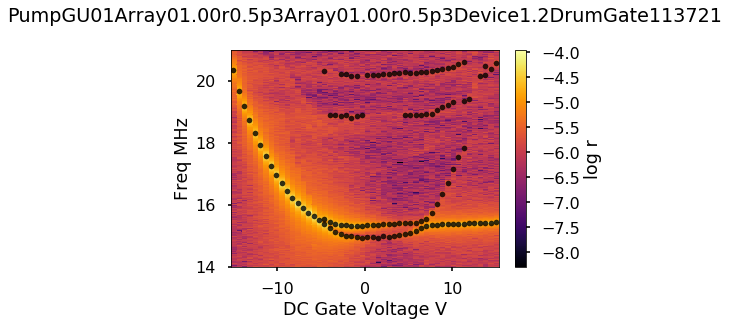

In [25]:
peakfreqsp2.plot(marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0, legend=False)
myheatmap(p.transpose(),'log r', cmap = 'inferno')
plt.title(file + '\n');

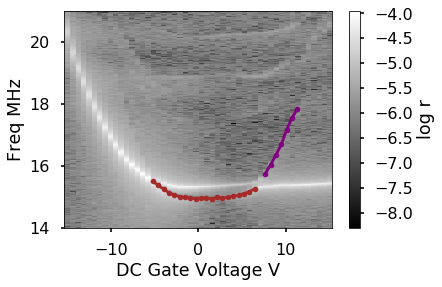

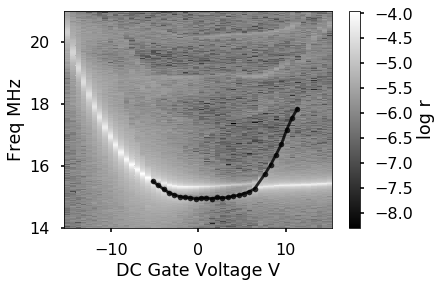

In [26]:
myheatmap(p.transpose(),'log r', cmap = 'gray')

bottomofcurve = peakfreqsp2.iloc[14:34,0]
sideofcurve = peakfreqsp2.iloc[6:13,1]

bottomofcurve.plot(marker ='.', color='brown')
sideofcurve.plot(marker ='.', color = 'purple')

wholecurve = pd.concat([sideofcurve,bottomofcurve])

plt.figure();
myheatmap(p.transpose(),'log r', cmap = 'gray')
wholecurve.plot(marker = '.', color = 'k', alpha = .8) #,linestyle=None, linewidth=0, legend=False)

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: numpy.arange


(13.992985972, 21.0)

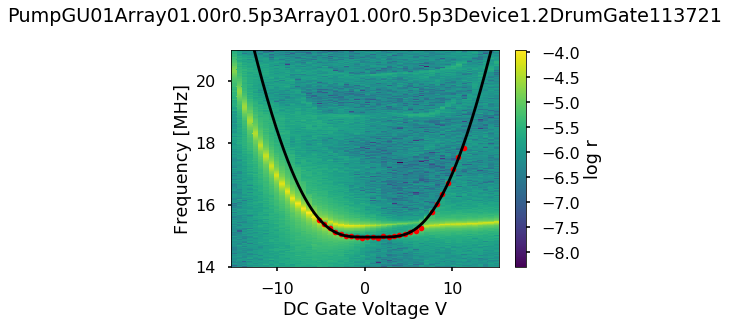

In [27]:

## data to be fit
data=wholecurve.values
x=wholecurve.index.values

## Initial guess for parameters.
params = lmfit.Parameters()
params.add('A', value=100, vary=True)
params.add('B', value=1, vary=True) 
params.add('C', value=1 , vary=True)
params.add('D', value=1, vary=True)
params.add('sigma0', value=1, vary=True)
params.add('offset', value=0, vary=True)

## perform the fit
out = lmfit.minimize(Wresidual, params, args=(x, data),nan_policy='propagate')
display(out) # display all the results

## Plot the fitting result.
V = frange(p.index.values.min(), p.index.values.max(), .001)
# fit parameters
A = out.params['A'].value  
B = out.params['B'].value  
C = out.params['C'].value  
D = out.params['D'].value  
sigma0 = out.params['sigma0'].value  
offset = out.params['offset'].value  



## display the results
#display(out.params)


##  plot fit with heatmap
plt.figure();
myheatmap(p.transpose(),'log r')
wholecurve.plot( marker = '.', color='red',linestyle= 'None', legend=False)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(V,W(V,A,B,C,D,sigma0, offset), 'k')
plt.ylim(ymax=21.)

In [28]:
df

Green X   Green Y             x             y             r     phase  \
0     -2.997559  6.047609 -3.460000e-07  3.580000e-07  4.980000e-07  2.338881   
1     -2.997559  6.047609 -2.900000e-08  1.412000e-06  1.412000e-06  1.591452   
2     -2.997559  6.047609 -2.350000e-07  4.270000e-07  4.870000e-07  2.073817   
3     -2.997559  6.047609 -2.680000e-07  5.150000e-07  5.810000e-07  2.049886   
4     -2.997559  6.047609  5.000000e-08  1.500000e-07  1.580000e-07  1.250276   
5     -2.997559  6.047609 -3.350000e-07  3.860000e-07  5.110000e-07  2.286065   
6     -2.997559  6.047609 -1.330000e-07  6.250000e-07  6.390000e-07  1.780378   
7     -2.997559  6.047609 -2.520000e-07  5.960000e-07  6.470000e-07  1.971475   
8     -2.997559  6.047609  2.210000e-07  4.980000e-07  5.440000e-07  1.152894   
9     -2.997559  6.047609  2.820000e-07  1.132000e-06  1.167000e-06  1.326885   
10    -2.997559  6.047609  2.840000e-07  5.100000e-07  5.840000e-07  1.062286   
11    -2.997559  6.047609  2.720000e-07  4.360000e-07  5.140000e-07  1.013093   
12    -2.997559  6.047609 -3.850000e-07  7.550000e-07  8.480000e-07  2.042452   
13    -2.997559  6.047609  4.430000e-07  1.270000e-06  1.345000e-06  1.235095   
14    -2.997559  6.047609 -5.300000e-08  4.830000e-07  4.860000e-07  1.679418   
15    -2.997559  6.047609  5.080000e-07  4.270000e-07  6.640000e-07  0.698274   
16    -2.997559  6.047609  5.160000e-07  7.140000e-07  8.810000e-07  0.944381   
17    -2.997559  6.047609 -5.500000e-08  3.820000e-07  3.860000e-07  1.713772   
18    -2.997559  6.047609  4.190000e-07  5.650000e-07  7.030000e-07  0.932654   
19    -2.997559  6.047609  5.890000e-07  1.390000e-07  6.050000e-07  0.231100   
20    -2.997559  6.047609  5.590000e-07  3.790000e-07  6.750000e-07  0.595953   
21    -2.997559  6.047609  5.200000e-07  4.100000e-08  5.210000e-07  0.078327   
22    -2.997559  6.047609  1.171000e-06  1.760000e-07  1.184000e-06  0.149080   
23    -2.997559  6.047609  1.008000e-06  1.570000e-07  1.020000e-06  0.154397   
24    -2.997559  6.047609  4.170000e-07  8.310000e-07  9.300000e-07  1.105904   
25    -2.997559  6.047609  1.002000e-06  3.530000e-07  1.062000e-06  0.338587   
26    -2.997559  6.047609  5.720000e-07  2.750000e-07  6.350000e-07  0.448120   
27    -2.997559  6.047609  4.230000e-07  5.870000e-07  7.230000e-07  0.946205   
28    -2.997559  6.047609  9.220000e-07  2.320000e-07  9.510000e-07  0.246811   
29    -2.997559  6.047609  5.940000e-07 -1.530000e-07  6.140000e-07 -0.251270   
...         ...       ...           ...           ...           ...       ...   
24970 -2.997559  6.047609  6.580000e-07  2.542000e-06  2.626000e-06  1.317577   
24971 -2.997559  6.047609  7.530000e-07  2.614000e-06  2.720000e-06  1.290390   
24972 -2.997559  6.047609  1.112000e-06  2.734000e-06  2.951000e-06  1.184589   
24973 -2.997559  6.047609  1.776000e-06  1.847000e-06  2.562000e-06  0.805080   
24974 -2.997559  6.047609  1.402000e-06  1.472000e-06  2.033000e-06  0.809585   
24975 -2.997559  6.047609  9.340000e-07  1.067000e-06  1.418000e-06  0.851785   
24976 -2.997559  6.047609  1.800000e-06  8.820000e-07  2.004000e-06  0.455898   
24977 -2.997559  6.047609  7.740000e-07  9.350000e-07  1.214000e-06  0.879496   
24978 -2.997559  6.047609  9.690000e-07  4.920000e-07  1.087000e-06  0.470344   
24979 -2.997559  6.047609  1.616000e-06  4.950000e-07  1.690000e-06  0.297534   
24980 -2.997559  6.047609  1.203000e-06  2.670000e-07  1.232000e-06  0.218461   
24981 -2.997559  6.047609  1.082000e-06  2.120000e-07  1.102000e-06  0.193534   
24982 -2.997559  6.047609  1.309000e-06  2.600000e-07  1.334000e-06  0.195723   
24983 -2.997559  6.047609  7.860000e-07  9.020000e-07  1.196000e-06  0.853865   
24984 -2.997559  6.047609  6.790000e-07  6.910000e-07  9.690000e-07  0.793736   
24985 -2.997559  6.047609  9.850000e-07  5.670000e-07  1.136000e-06  0.522186   
24986 -2.997559  6.047609  5.260000e-07  6.660000e-07  8.480000e-07  0.902330   
24987 -2.997559  6.047609  6.670000e-07

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\vhorowit\AppData\Local\conda\conda\en

(14.497995992000002, 16.504008016)

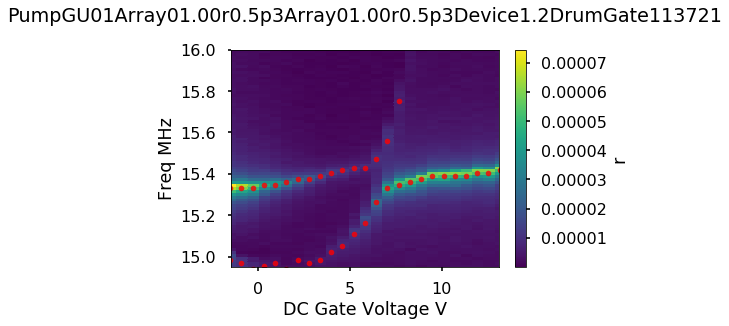

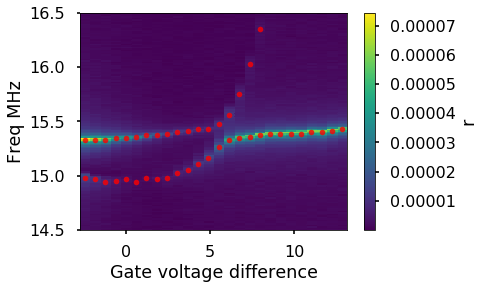

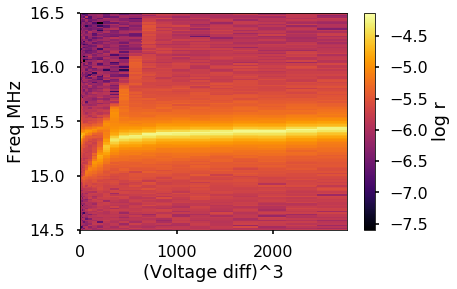

<Figure size 432x288 with 0 Axes>

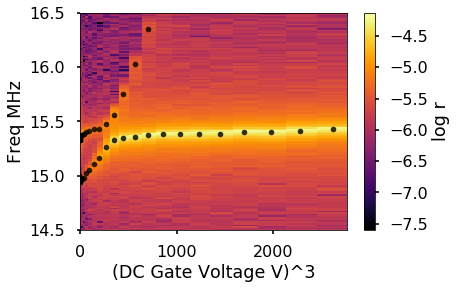

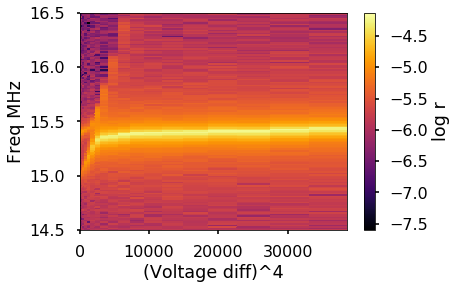

<Figure size 432x288 with 0 Axes>

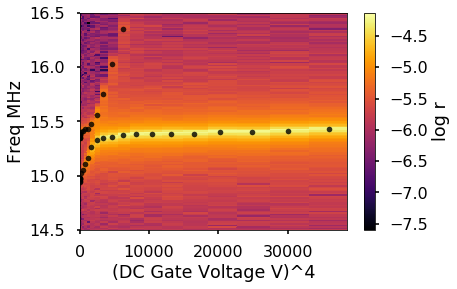

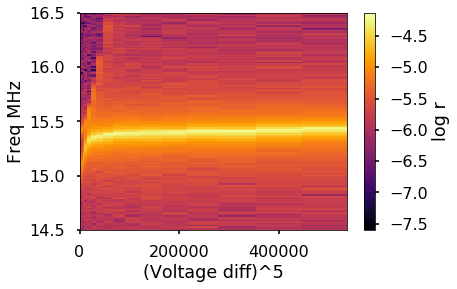

<Figure size 432x288 with 0 Axes>

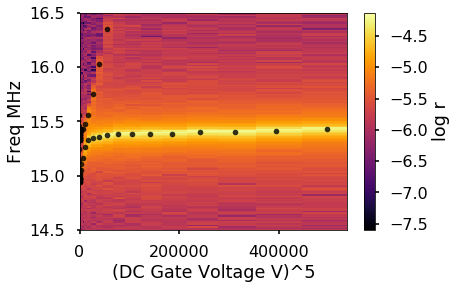

In [29]:
minfreq = 14.5
maxfreq = 16.5
minV = -2
maxV = 14.1
lf = df['Freq MHz'] > minfreq 
hf = df['Freq MHz'] < maxfreq
lv = df['DC Gate Voltage V'] > minV
hv = df['DC Gate Voltage V'] < maxV
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
myheatmap(n.transpose(), 'r')
ax = plt.gca()
plt.title(file + '\n');
peakfreqsp2.plot(marker='.', color='r', alpha=0.8, linestyle=None, linewidth=0, legend=False, ax=ax)
plt.xlim(-1.5,13.1)
plt.ylim(14.95,16);


noffset = offsetindex(n,offset,'Gate voltage difference')
peakfreqsp2offset=offsetindex(peakfreqsp2,offset,'Gate voltage difference')

plt.figure()
myheatmap(noffset.transpose(), 'r')
xlimits = plt.xlim()  # return the current xlim
ylimits = plt.ylim()  # return the current ylim
ax = plt.gca()
peakfreqsp2offset.plot(marker='.', color='r', alpha=0.8, linestyle=None, linewidth=0, legend=False, ax=ax )
plt.xlim(xlimits)   # set the xlim to left, right
plt.ylim(ylimits)   # set the ylim to left, right

pospeakfreqsp2 = peakfreqsp2[peakfreqsp2.index>0]
pospeakfreqsp2offset = peakfreqsp2offset[peakfreqsp2offset.index>0]

pow=3
Vpowplot(df[lf][hf][lv][hv],pow, transpose = True , offset=offset)
plt.figure()
Vpowplot(df[lf][hf][lv][hv],pow, transpose = True , offset=0)
xlimits = plt.xlim()  # return the current xlim
ylimits = plt.ylim()  # return the current ylim
plt.plot(peakfreqsp2.index**pow,peakfreqsp2,marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0,  )
plt.xlim(xlimits)   # set the xlim to left, right
plt.ylim(ylimits)   # set the ylim to left, right

Vpowplot(df[lf][hf][lv][hv], 4, transpose = True , offset=offset)
plt.figure()
Vpowplot(df[lf][hf][lv][hv], 4, transpose = True)
xlimits4 = plt.xlim()  # return the current xlim
ylimits4 = plt.ylim()  # return the current ylim
plt.plot(pospeakfreqsp2.index**4,pospeakfreqsp2,marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0,  )
plt.xlim(xlimits4)   # set the xlim to left, right
plt.ylim(ylimits4)   # set the ylim to left, right

pow=5
Vpowplot(df[lf][hf][lv][hv], pow, transpose = True , offset=offset)
plt.figure()
Vpowplot(df[lf][hf][lv][hv], pow, transpose = True )
xlimits = plt.xlim()  # return the current xlim
ylimits = plt.ylim()  # return the current ylim
plt.plot(peakfreqsp2.index**pow,peakfreqsp2,marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0,  )
plt.xlim(xlimits)   # set the xlim to left, right
plt.ylim(ylimits)   # set the ylim to left, right

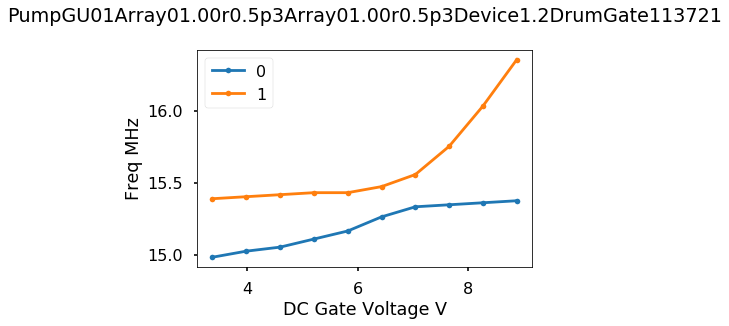

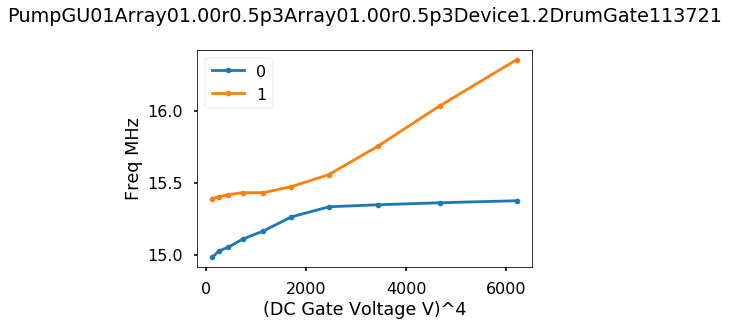

In [30]:
minV = 3
maxV = 9
lf = pospeakfreqsp2 > minfreq 
hf = pospeakfreqsp2 < maxfreq
lv = pospeakfreqsp2.index > minV
hv = pospeakfreqsp2.index < maxV

zoomedpeakfreqsp2 = (pospeakfreqsp2[lf][hf][hv]).iloc[:,0:2]
lv = zoomedpeakfreqsp2.index > minV
zoomedpeakfreqsp2 = zoomedpeakfreqsp2[lv]

zoomedpeakfreqsp2.plot(marker ='.')
plt.title(file + '\n');
plt.ylabel('Freq MHz')

pow4zoomedpeakfreqsp2 = zoomedpeakfreqsp2.copy()
pow4zoomedpeakfreqsp2.index = zoomedpeakfreqsp2.index**4
pow4zoomedpeakfreqsp2.index.name = '(DC Gate Voltage V)^4'


pow4zoomedpeakfreqsp2.plot(marker ='.')
plt.title(file + '\n');
plt.ylabel('Freq MHz');

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: numpy.arange
  # This is added back by InteractiveShellApp.init_path()


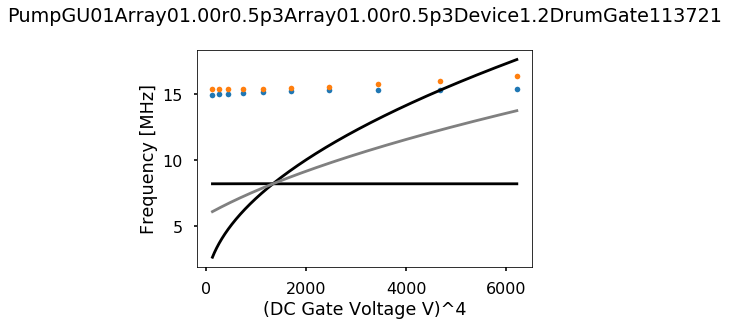

In [31]:
## Manually choose test parameters; these will be the starting points for the fit.
k1 = 10   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = .15    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = 20   # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = 0.1;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.


#dk = frange(-1,1 , .1)
#dk = peakfreqsp.index.values
dk = frange(pow4zoomedpeakfreqsp2.index.values.min(), pow4zoomedpeakfreqsp2.index.values.max(), 1)
#dk = frange(-10, 1000, .001)


## Plot the guesses to find a good starting guess
pow4zoomedpeakfreqsp2.plot( marker = '.', linestyle = 'None', legend=None)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,middle1(dk, m1,m2,k,k1), 'gray')

del m1,m2,k,k1,dk

array([16.35671343, 16.03406814, 15.75350701, 15.55711423, 15.47294589,
       15.43086172, 15.43086172, 15.41683367, 15.40280561, 15.38877756])

array([15.3747495 , 15.36072144, 15.34669339, 15.33266533, 15.26252505,
       15.16432866, 15.10821643, 15.05210421, 15.0240481 , 14.98196393])

array([6210.46019373, 4667.00729046, 3430.35714314, 2457.87800039,
       1707.76372236, 1144.57024036,  733.48664916,  444.68428175,
        250.78918134,  128.60084731])

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: numpy.arange


<Figure size 432x288 with 0 Axes>

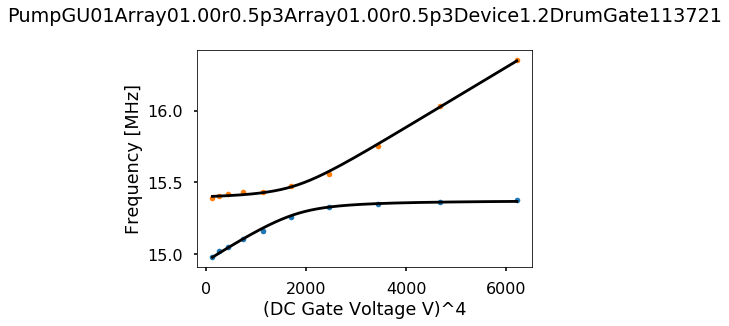

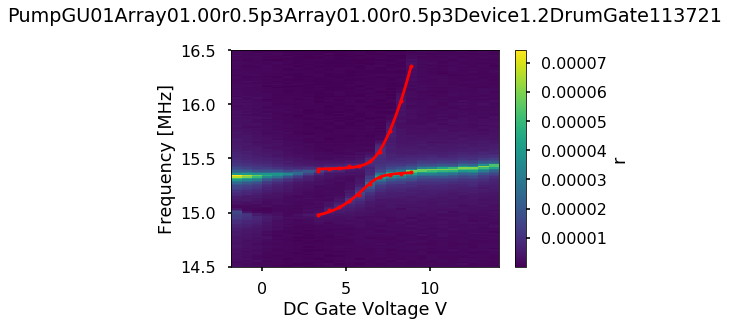

In [32]:
#upperantim = lmfit.Model(upperantifn)
#lowerantim = lmfit.Model(lowerantifn)

# input guesses for the fitting parameters
params2 = lmfit.Parameters()
params2.add('k1', value=10, vary=True)
params2.add('m1', value=.15, vary=True) 
params2.add('m2', value=20 , vary=True)
params2.add('k', value=0.1, vary=True, min=0)

"""## plot the data
myheatmap((pow4zoomedpeakfreqsp2).transpose(), cmap = 'gray') # cutting out last row because it is incomplete
pow4zoomedpeakfreqsp2.plot( marker = '.',  linestyle= 'None', legend=True)
plt.title(file + '\n');"""

## data to be fit
dat1=pow4zoomedpeakfreqsp2.iloc[:,1].values
dat2=pow4zoomedpeakfreqsp2.iloc[:,0].values
x=pow4zoomedpeakfreqsp2.index.values

display(dat1)
display(dat2)
display(x)

## perform the fit
out = lmfit.minimize(anticrossingresidual, params2, args=(x, dat1, dat2),nan_policy='propagate')
display(out) # display all the results

## Plot the fitting result.
dk = frange(pow4zoomedpeakfreqsp2.index.values.min(), pow4zoomedpeakfreqsp2.index.values.max(), .1)
# fit parameters
k1 = out.params['k1'].value   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = out.params['m1'].value    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = out.params['m2'].value    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = out.params['k'].value;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

## display the results
#display(out.params)


##  plot without heatmap
plt.figure();
pow4zoomedpeakfreqsp2.plot( marker = '.', linestyle= 'None', legend=False)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')




plt.figure()
ax = myheatmap(n.transpose(), 'r',)# cmap ='') # viridas
zoomedpeakfreqsp2.plot(color='red', marker = '.',markersize=8, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'red')
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'red')
#del m1,m2,k,k1,dk

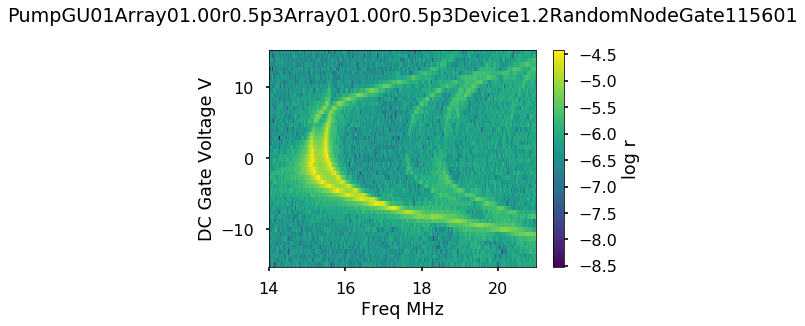

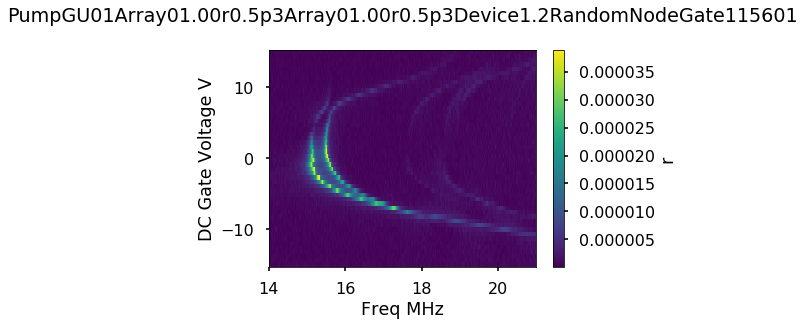

In [33]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601'
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(9)
p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
p3 = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(p, 'log r')
plt.title(file + '\n');
plt.figure()
myheatmap(p3, 'r')
plt.title(file + '\n');

0

Gate voltage: 14.9996 V


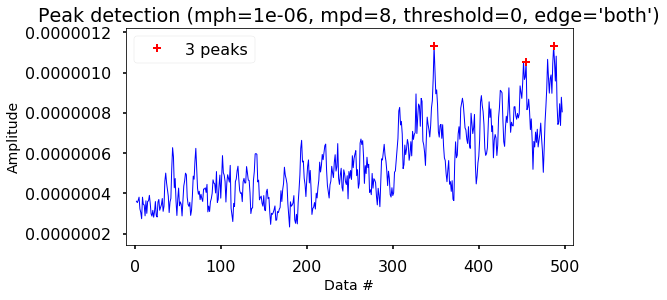

[348 455 487]
[348, 455, 487]


1

Gate voltage: 14.38773 V


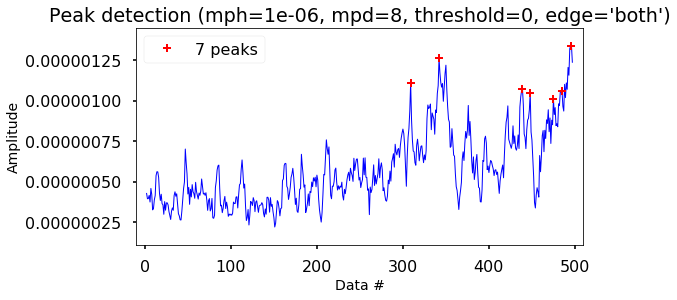

[309 342 439 448 475 485 495]
[309, 342, 439, 448, 475, 485, 495]


2

Gate voltage: 13.77534 V


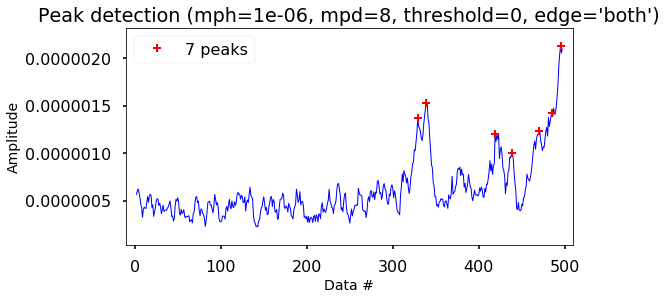

[329 339 419 439 470 485 495]
[329, 339, 419, 439, 470, 485, 495]


3

Gate voltage: 13.16336 V


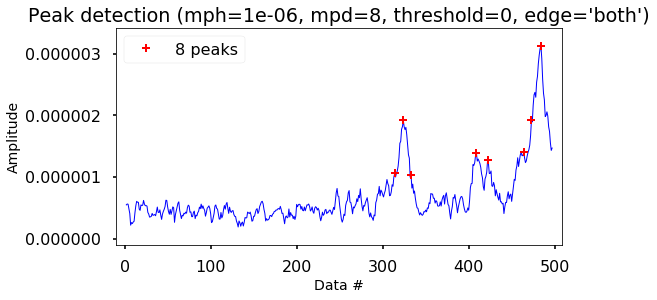

[314 324 333 409 422 464 473 484]
[324, 409, 422, 464, 473]


4

Gate voltage: 12.55071 V


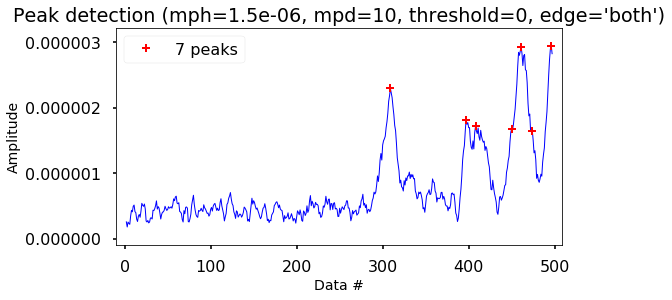

[309 397 408 450 461 474 496]
[309, 397, 408, 461, 496]


5

Gate voltage: 11.93879 V


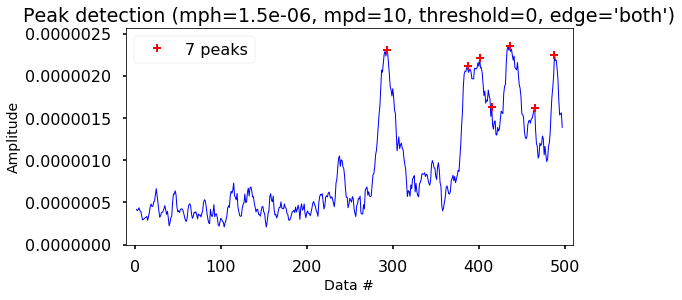

[293 387 401 415 436 465 488]
[293, 387, 401, 436, 465, 488]


6

Gate voltage: 11.32654 V


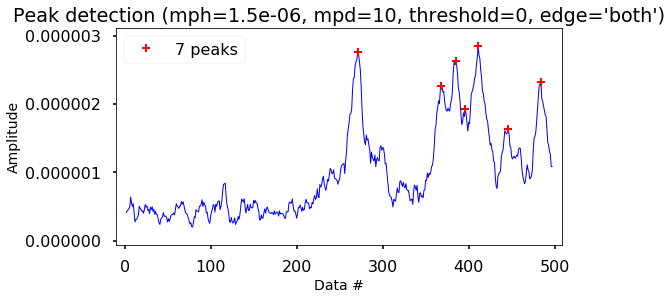

[271 368 385 396 411 446 484]
[271, 368, 385, 396, 411, 446, 484]


7

Gate voltage: 10.71422 V


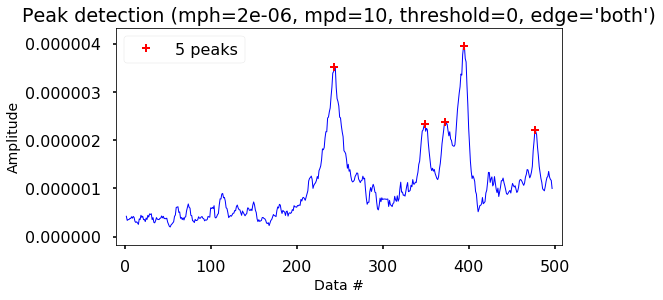

[244 349 372 395 477]
[244, 349, 372, 395, 477]


8

Gate voltage: 10.10201 V


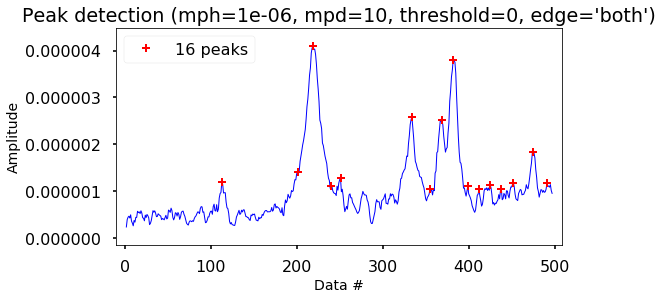

[113 201 219 240 251 334 355 369 382 399 412 425 438 452 475 491]
[113, 219, 251, 334, 369, 382, 475]


9

Gate voltage: 9.489927 V


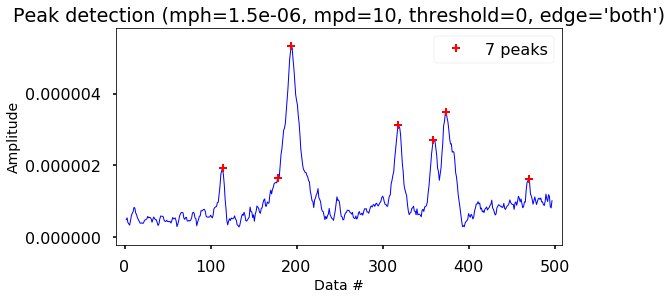

[114 178 194 318 359 374 470]
[114, 178, 194, 318, 359, 374, 470]


10

Gate voltage: 8.87731 V


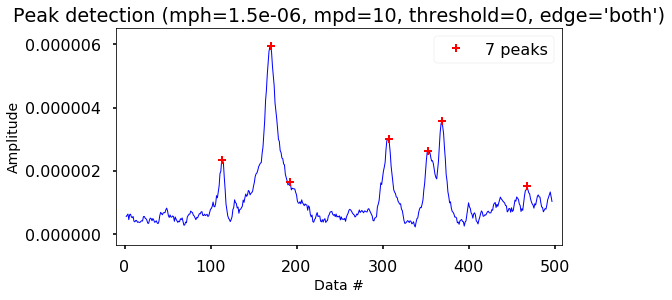

[113 170 192 307 353 369 468]
[113, 170, 192, 307, 353, 369, 468]


11

Gate voltage: 8.265311 V


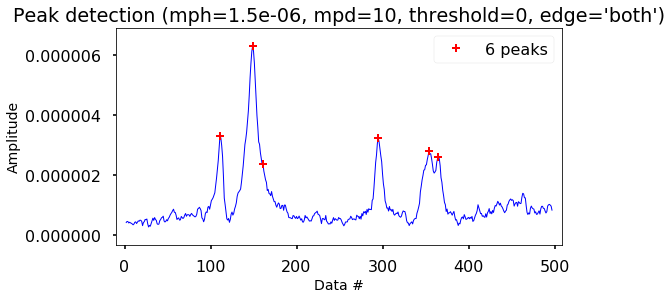

[111 149 161 295 354 365]
[111, 149, 295, 354, 365]


12

Gate voltage: 7.65305 V


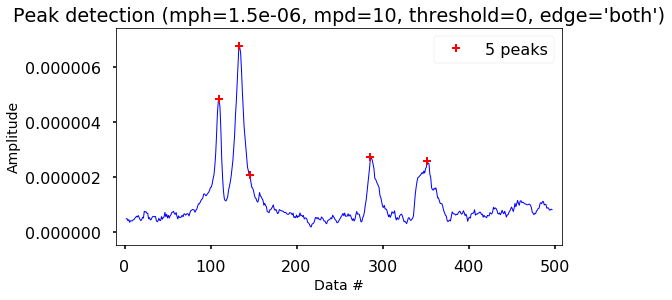

[110 133 146 286 352]
[110, 133, 286, 352]


13

Gate voltage: 7.041094 V


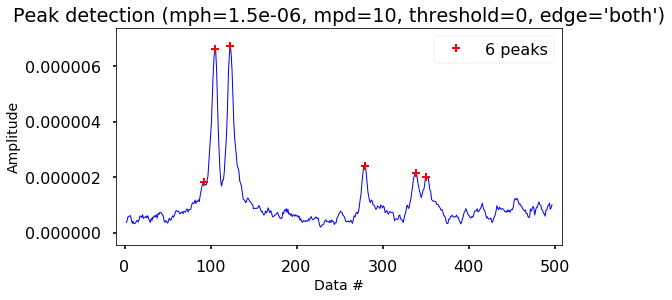

[ 92 105 123 280 339 350]
[105, 123, 280, 339, 350]


14

Gate voltage: 6.428456 V


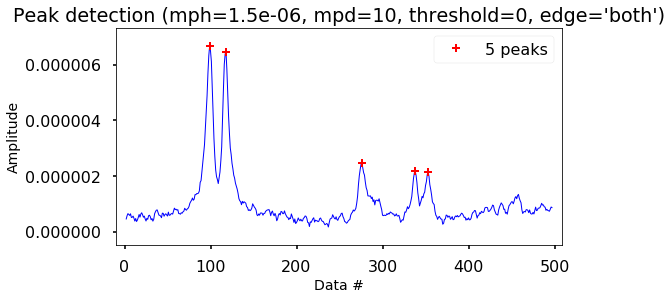

[ 99 118 276 338 353]
[99, 118, 276, 338, 353]


15

Gate voltage: 5.816488 V


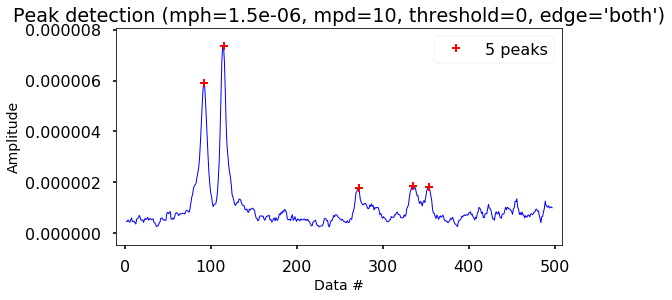

[ 92 115 272 335 354]
[92, 115, 272, 335, 354]


16

Gate voltage: 5.204131 V


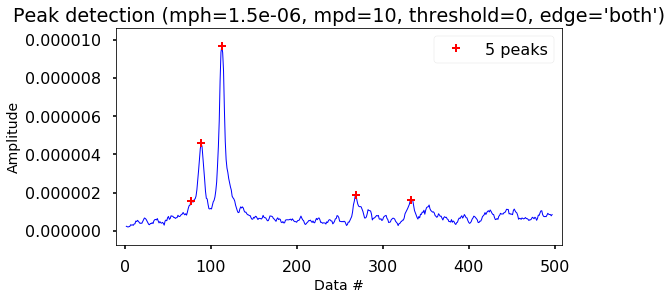

[ 77  89 113 269 333]
[89, 113, 269, 333]


17

Gate voltage: 4.592134 V


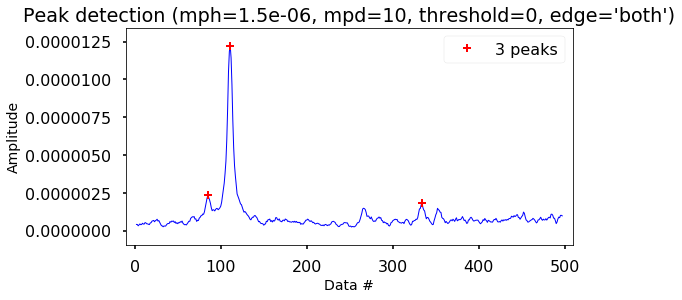

[ 85 111 334]
[85, 111, 334]


18

Gate voltage: 3.979494 V


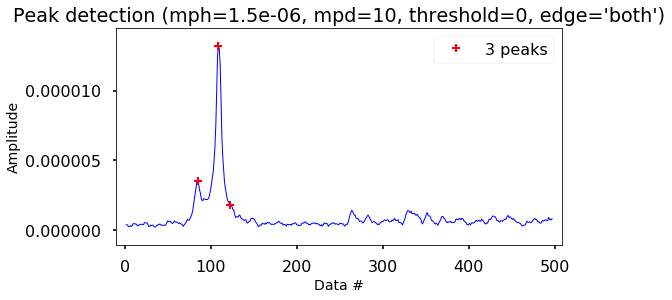

[ 85 109 123]
[85, 109]


19

Gate voltage: 3.367545 V


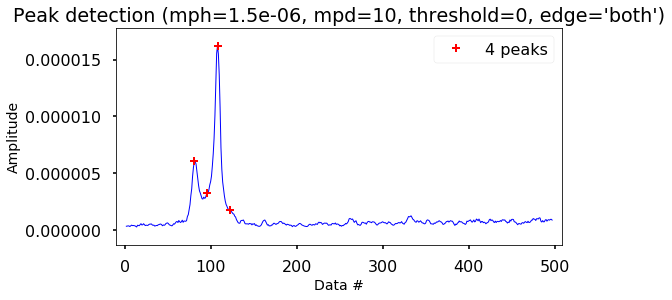

[ 81  96 108 123]
[81, 108]


20

Gate voltage: 2.755216 V


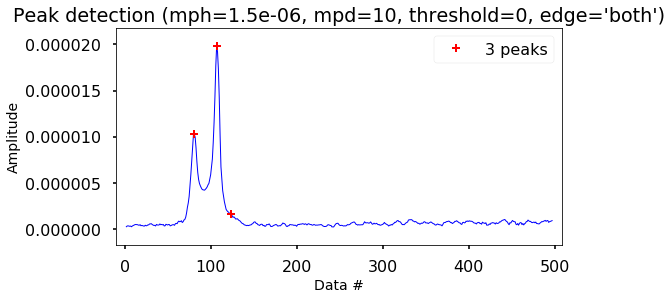

[ 81 107 124]
[81, 107]


21

Gate voltage: 2.143193 V


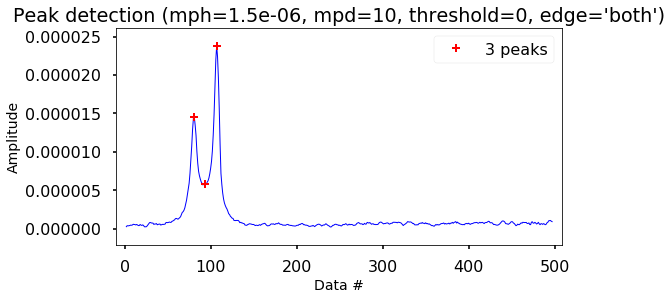

[ 81  94 107]
[81, 107]


22

Gate voltage: 1.530563 V


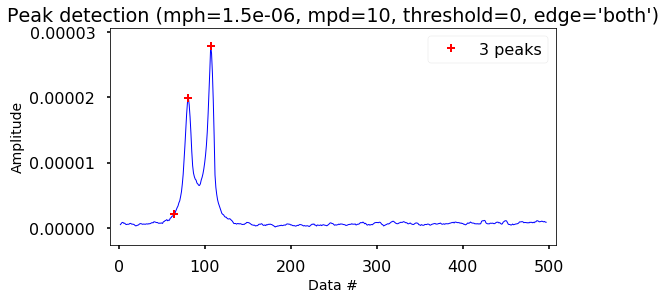

[ 64  81 107]
[81, 107]


23

Gate voltage: 0.9183441 V


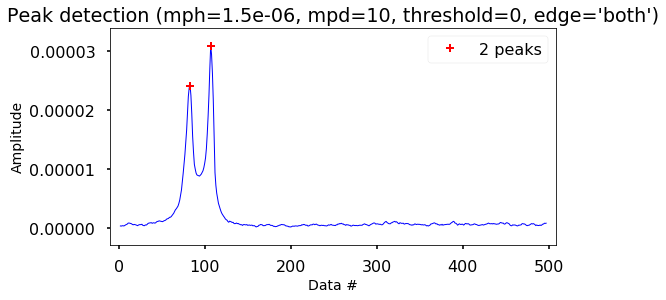

[ 83 107]
[83, 107]


24

Gate voltage: 0.3061056 V


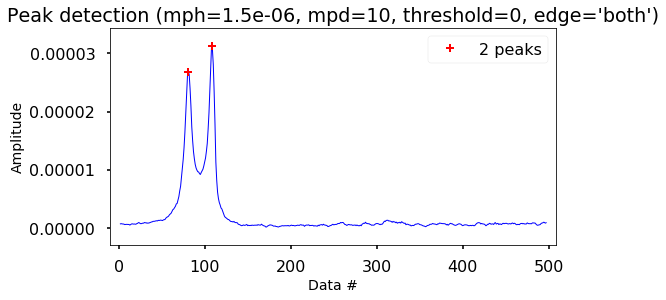

[ 81 108]
[81, 108]


25

Gate voltage: -0.3060924 V


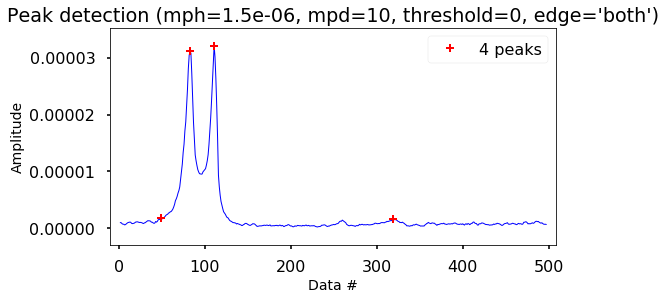

[ 49  83 111 319]
[83, 111, 319]


26

Gate voltage: -0.9183692 V


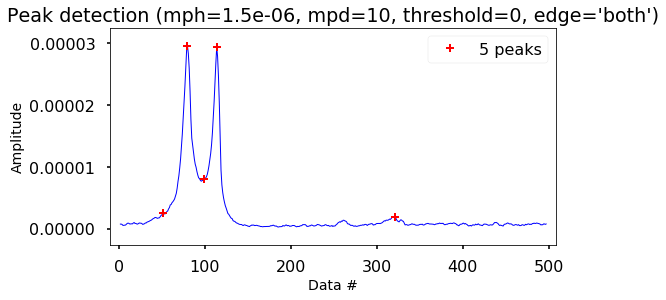

[ 52  80  99 114 321]
[80, 114, 321]


27

Gate voltage: -1.530588 V


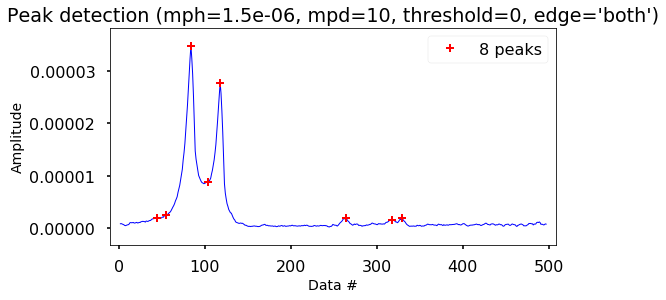

[ 44  55  84 104 118 264 318 329]
[84, 118, 264, 318, 329]


28

Gate voltage: -2.14286 V


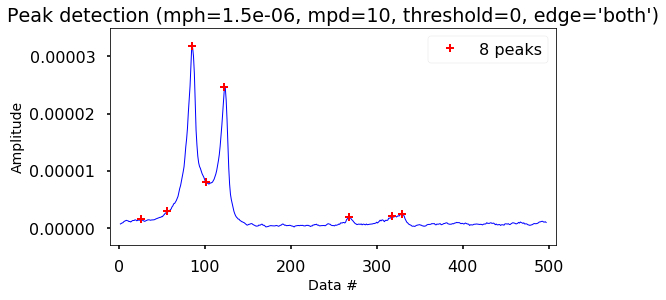

[ 26  56  85 102 123 268 318 329]
[85, 123, 268, 318, 329]


29

Gate voltage: -2.754876 V


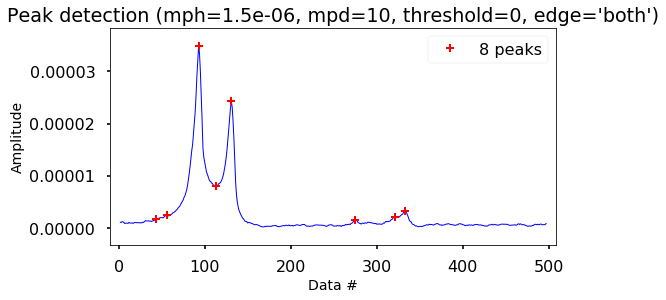

[ 43  56  93 113 131 275 321 333]
[93, 131, 275, 321, 333]


30

Gate voltage: -3.36755 V


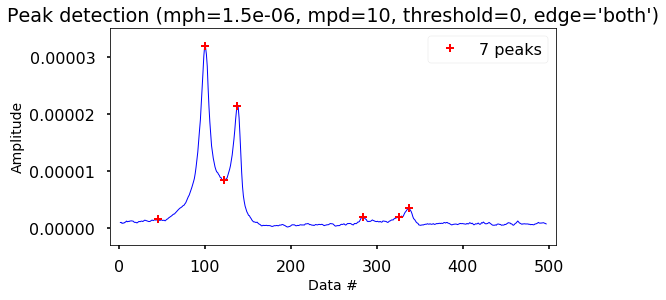

[ 46 100 123 138 284 326 337]
[100, 138, 284, 326, 337]


31

Gate voltage: -3.979489 V


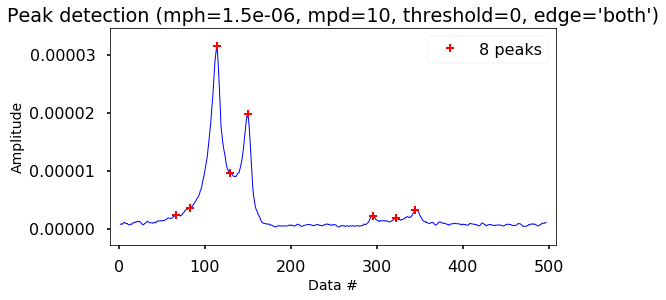

[ 67  83 114 130 150 296 323 345]
[114, 150, 296, 323, 345]


32

Gate voltage: -4.591815 V


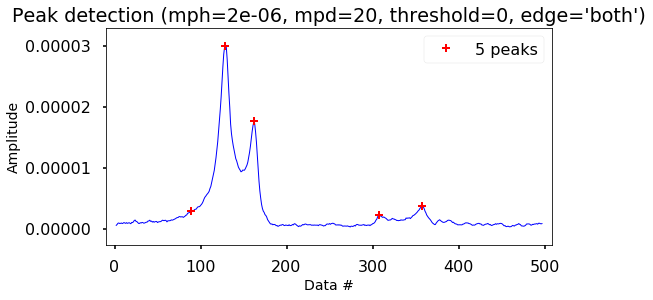

[ 89 129 162 307 358]
[129, 162, 307, 358]


33

Gate voltage: -5.204156 V


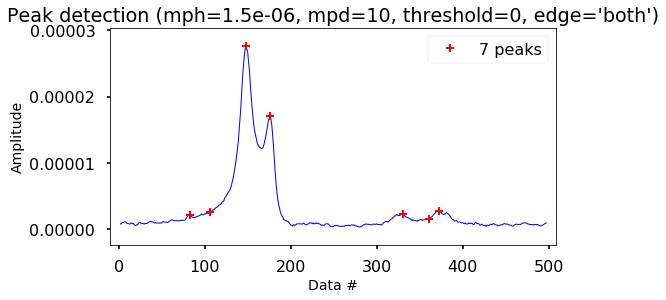

[ 83 106 148 176 330 361 372]
[148, 176, 330, 372]


34

Gate voltage: -5.816492 V


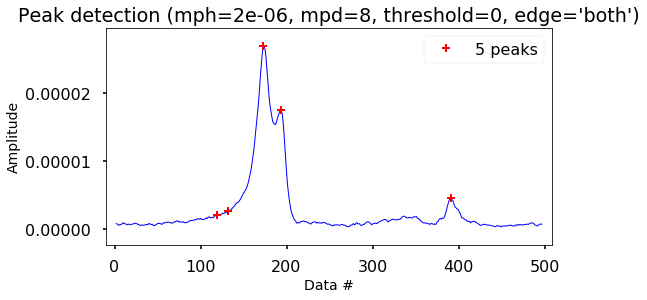

[119 132 173 193 391]
[173, 193, 391]


35

Gate voltage: -6.428511 V


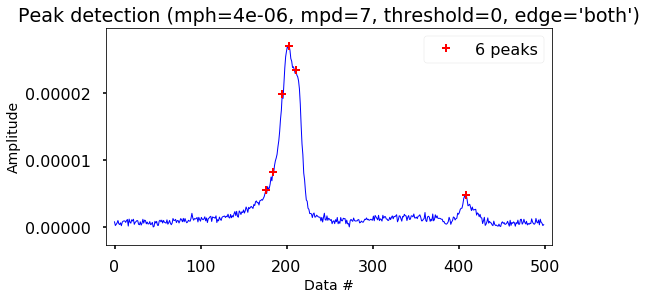

[176 184 195 203 211 409]
[203, 211, 409]


36

Gate voltage: -7.04114 V


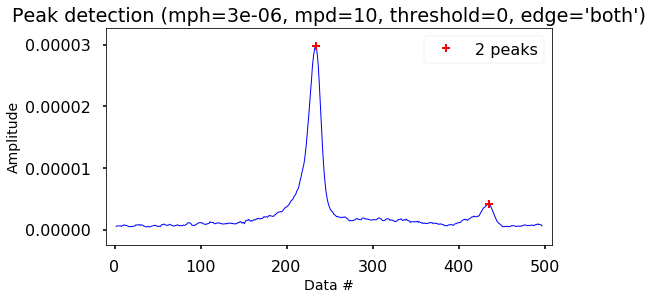

[234 435]
[234, 435]


37

Gate voltage: -7.653137 V


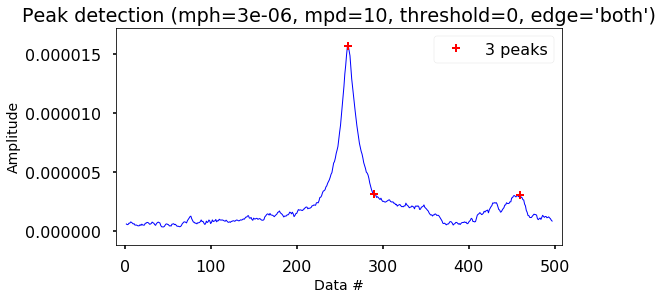

[260 290 460]
[260, 460]


38

Gate voltage: -8.265349 V


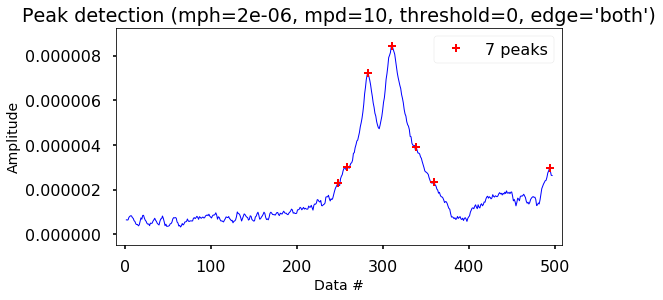

[248 259 283 311 339 360 494]
[248, 259, 283, 311, 494]


39

Gate voltage: -8.877711 V


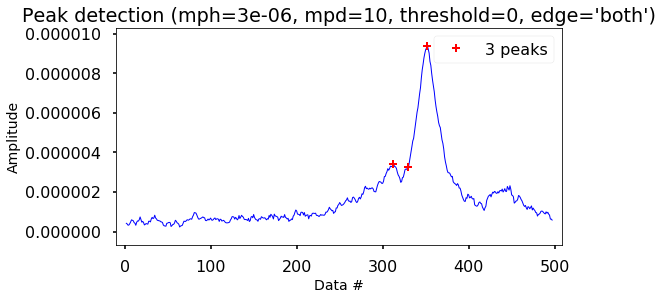

[312 329 352]
[312, 352]


40

Gate voltage: -9.489975 V


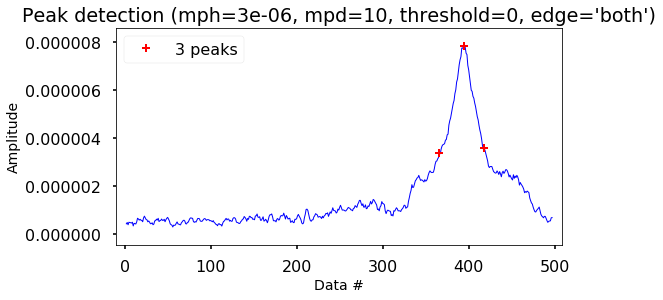

[366 395 418]
[395]


41

Gate voltage: -10.102 V


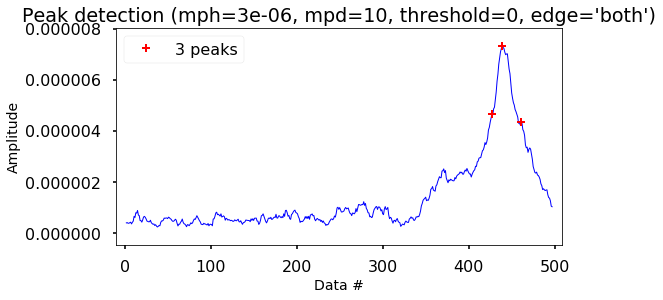

[427 439 461]
[439]


42

Gate voltage: -10.71461 V


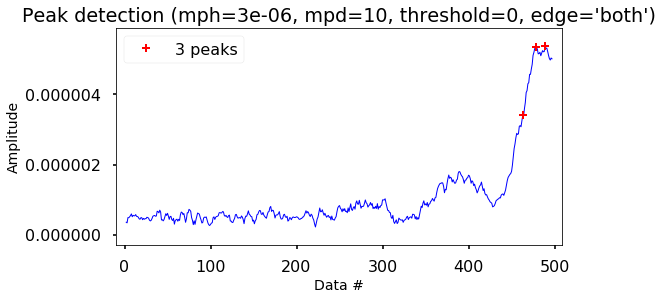

[463 478 489]
[478, 489]


43

Gate voltage: -11.32659 V
2.368e-06


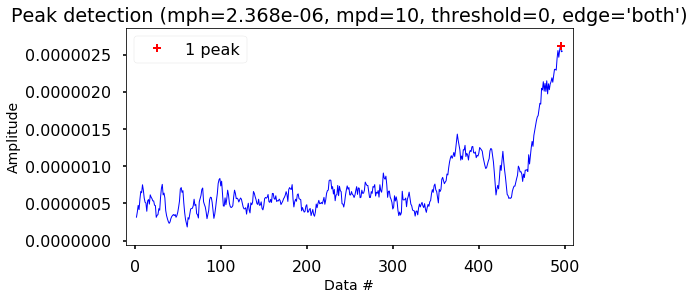

[495]
[495]


44

Gate voltage: -11.93891 V
1.8544000000000002e-06


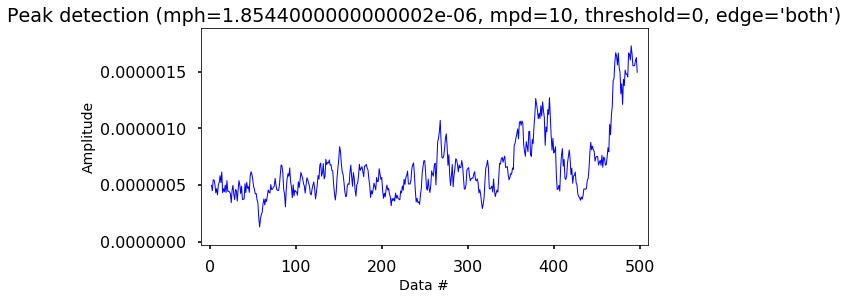

[]
[]


45

Gate voltage: -12.55082 V
1.7032e-06


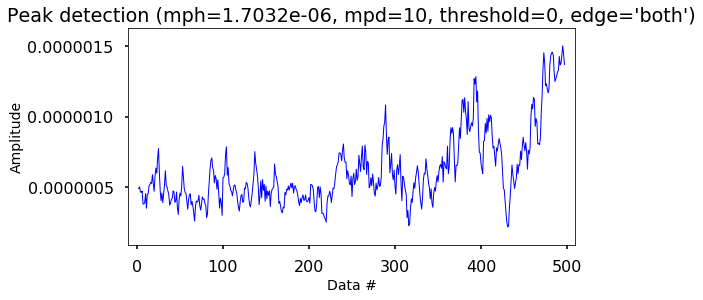

[]
[]


46

Gate voltage: -13.16344 V
1.604e-06


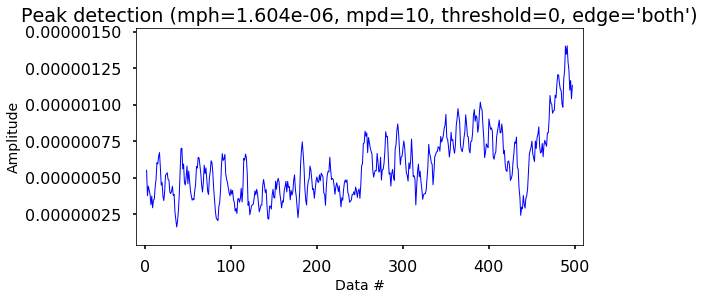

[]
[]


47

Gate voltage: -13.77543 V
1.3304000000000002e-06


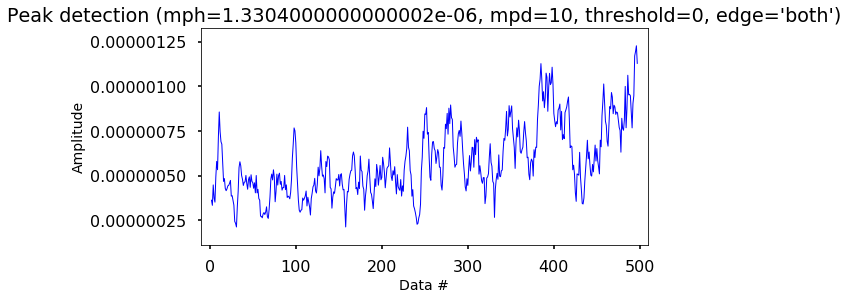

[]
[]


48

Gate voltage: -14.38812 V
1.3464000000000001e-06


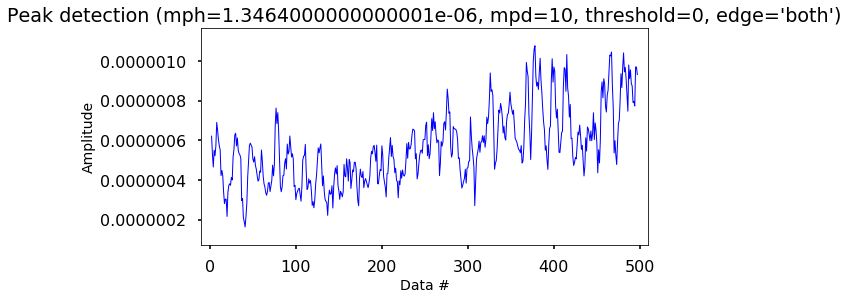

[]
[]


49

Gate voltage: -15.00003 V
1.2432000000000002e-06


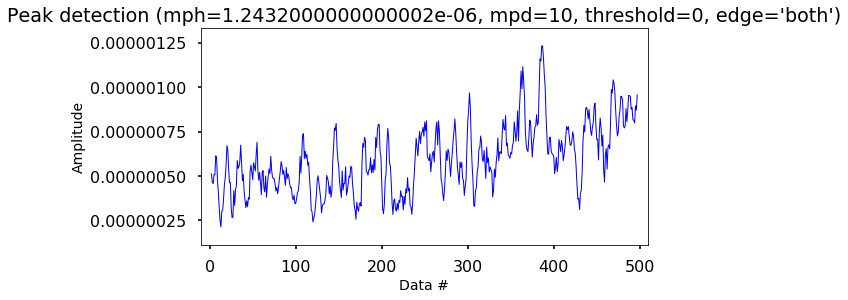

[]
[]


[[348, 455, 487],
 [309, 342, 439, 448, 475, 485, 495],
 [329, 339, 419, 439, 470, 485, 495],
 [324, 409, 422, 464, 473],
 [309, 397, 408, 461, 496],
 [293, 387, 401, 436, 465, 488],
 [271, 368, 385, 396, 411, 446, 484],
 [244, 349, 372, 395, 477],
 [113, 219, 251, 334, 369, 382, 475],
 [114, 178, 194, 318, 359, 374, 470],
 [113, 170, 192, 307, 353, 369, 468],
 [111, 149, 295, 354, 365],
 [110, 133, 286, 352],
 [105, 123, 280, 339, 350],
 [99, 118, 276, 338, 353],
 [92, 115, 272, 335, 354],
 [89, 113, 269, 333],
 [85, 111, 334],
 [85, 109],
 [81, 108],
 [81, 107],
 [81, 107],
 [81, 107],
 [83, 107],
 [81, 108],
 [83, 111, 319],
 [80, 114, 321],
 [84, 118, 264, 318, 329],
 [85, 123, 268, 318, 329],
 [93, 131, 275, 321, 333],
 [100, 138, 284, 326, 337],
 [114, 150, 296, 323, 345],
 [129, 162, 307, 358],
 [148, 176, 330, 372],
 [173, 193, 391],
 [203, 211, 409],
 [234, 435],
 [260, 460],
 [248, 259, 283, 311, 494],
 [312, 352],
 [395],
 [439],
 [478, 489],
 [495],
 [],
 [],
 [],
 [],
 [],

[Float64Index([18.881763527, 20.382765531, 20.831663327], dtype='float64', name='Freq MHz'),
 Float64Index([18.334669339,  18.79759519, 20.158316633, 20.284569138,
               20.663326653, 20.803607214, 20.943887776],
              dtype='float64', name='Freq MHz'),
 Float64Index([18.615230461, 18.755511022, 19.877755511, 20.158316633,
               20.593186373, 20.803607214, 20.943887776],
              dtype='float64', name='Freq MHz'),
 Float64Index([18.54509018, 19.73747495, 19.919839679, 20.509018036,
               20.635270541],
              dtype='float64', name='Freq MHz'),
 Float64Index([18.334669339, 19.569138277, 19.723446894, 20.466933868,
               20.957915832],
              dtype='float64', name='Freq MHz'),
 Float64Index([18.110220441, 19.428857715, 19.625250501, 20.116232465,
               20.523046092, 20.845691383],
              dtype='float64', name='Freq MHz'),
 Float64Index([17.801603206, 19.162324649, 19.400801603,  19.55511022,
               19.

0          1          2          3          4  \
DC Gate Voltage V                                                          
 14.999600         18.881764  20.382766  20.831663        NaN        NaN   
 14.387730         18.334669  18.797595  20.158317  20.284569  20.663327   
 13.775340         18.615230  18.755511  19.877756  20.158317  20.593186   
 13.163360         18.545090  19.737475  19.919840  20.509018  20.635271   
 12.550710         18.334669  19.569138  19.723447  20.466934  20.957916   
 11.938790         18.110220  19.428858  19.625251  20.116232  20.523046   
 11.326540         17.801603  19.162325  19.400802  19.555110  19.765531   
 10.714220         17.422846  18.895792  19.218437  19.541082  20.691383   
 10.102010         15.585170  17.072144  17.521042  18.685371  19.176353   
 9.489927          15.599198  16.496994  16.721443  18.460922  19.036072   
 8.877310          15.585170  16.384770  16.693387  18.306613  18.951904   
 8.265311          15.557114  16.090180  18.138277  18.965932  19.120240   
 7.653050          15.543086  15.865731  18.012024  18.937876        NaN   
 7.041094          15.472946  15.725451  17.927856  18.755511  18.909820   
 6.428456          15.388778  15.655311  17.871743  18.741483  18.951904   
 5.816488          15.290581  15.613226  17.815631  18.699399  18.965932   
 5.204131          15.248497  15.585170  17.773547  18.671343        NaN   
 4.592134          15.192385  15.557114  18.685371        NaN        NaN   
 3.979494          15.192385  15.529058        NaN        NaN        NaN   
 3.367545          15.136273  15.515030        NaN        NaN        NaN   
 2.755216          15.136273  15.501002        NaN        NaN        NaN   
 2.143193          15.136273  15.501002        NaN        NaN        NaN   
 1.530563          15.136273  15.501002        NaN        NaN        NaN   
 0.918344          15.164329  15.501002        NaN        NaN        NaN   
 0.306106          15.136273  15.515030        NaN        NaN        NaN   
-0.306092          15.164329  15.557114  18.474950        NaN        NaN   
-0.918369          15.122244  15.599198  18.503006        NaN        NaN   
-1.530588          15.178357  15.655311  17.703407  18.460922  18.615230   
-2.142860          15.192385  15.725451  17.759519  18.460922  18.615230   
-2.754876          15.304609  15.837675  17.857715  18.503006  18.671343   
-3.367550          15.402806  15.935872  17.983968  18.573146  18.727455   
-3.979489          15.599198  16.104208  18.152305  18.531062  18.839679   
-4.591815          15.809619  16.272545  18.306613  19.022044        NaN   
-5.204156          16.076152  16.468938  18.629259  19.218437        NaN   
-5.816492          16.426854  16.707415  19.484970        NaN        NaN   
-6.428511          16.847695  16.959920  19.737475        NaN        NaN   
-7.041140          17.282565  20.102204        NaN        NaN        NaN   
-7.653137          17.647295  20.452906        NaN        NaN        NaN   
-8.265349          17.478958  17.633267  17.969940  18.362725  20.929860   
-8.877711          18.376754  18.937876        NaN        NaN        NaN   
-9.489975          19.541082        NaN        NaN        NaN        NaN   
-10.102000         20.158317        NaN        NaN        NaN        NaN   
-10.714610         20.705411  20.859719        NaN        NaN        NaN   
-11.326590         20.943888        NaN        NaN        NaN        NaN   
-11.938910               NaN        NaN        NaN        NaN        NaN   
-12.550820               NaN        NaN        NaN        NaN        NaN   
-13.163440               NaN        NaN        NaN        NaN        NaN   
-13.775430               NaN        NaN        NaN        NaN        NaN   
-14.388120               NaN        NaN        NaN        NaN        NaN   
-15.000030               NaN        NaN        NaN        NaN        NaN   

                           5          6  
DC Gate Voltage V               

In [34]:
# initialize peaks list
peaksint = []
freqlist = []


for i in range(len(p3)):
    data = p3.iloc[i]
    display(i)
    print("Gate voltage: " + str(p3.iloc[i].name) + " V")
    ## Manual adjustement
    if i <= 3:
        mph = 1e-6
        mpd = 8
    elif i == 7:
        mph = 2e-6
        mpd = 10
    elif i == 8:
        mph = 1e-6
        mpd = 10
    elif i == 32:
        mph = 2e-6
        mpd = 20
    elif i == 34:
        mph = 2e-6
        mpd = 8
    elif i == 38:
        mph = 2e-6
        mpd = 10
    elif i == 35:
        mph = 4e-6
        mpd = 7
    elif i >=43:
        mph = .8*data.max();
        print(mph)
        mpd = 10
    elif i >= 36:
        mph = 3e-6
        mpd = 10
    else:
        mph = 1.5e-6
        mpd = 10
    if i == 35:
        window = 1
    else:
        window = 5;
    res = detect_peaks(pd.DataFrame.rolling(data, window, center=True).sum()/window, 
             mph=mph, 
           #  threshold=1e-8,
             mpd=mpd,
             edge = 'both',
             show=True)
    print(res)
    ## seriously manually selected for this dataset
    if i ==27 or i == 28 or i ==29:
        res = list(res[j] for j in [2,4,5,6,7])
    elif i == 3:
        res = list(res[j] for j in [1,3,4,5,6])
    elif i == 4:
        res = list(res[j] for j in [0,1,2,4,6])
    elif i == 5:
        res = list(res[j] for j in [0,1,2,4,5,6])
    elif i == 8:
        res = list(res[j] for j in [0,2,4,5,7,8,14])
    elif i == 11:
        res = list(res[j] for j in [0,1,3,4,5])
    elif i == 12:
        res = list(res[j] for j in [0,1,3,4])
    elif i == 13:
        res = list(res[j] for j in [1,2,3,4,5])
    elif i == 18 or i==20:
        res = list(res[j] for j in [0,1])
    elif i==19 or i == 21 or i == 37:
        res = list(res[j] for j in [0,2] )
    elif i == 22:
        res = list(res[j] for j in [1,2])
    elif i == 25:
        res = list(res[j] for j in [1,2,3])
    elif i == 26:
        res = list(res[j] for j in [1,3,4])
    elif i == 30:
        res = list(res[j] for j in [1,3,4,5,6])
    elif i == 31:
        res = list(res[j] for j in [2,4,5,6,7])
    elif i == 32 or i == 16:
        res = list(res[j] for j in [1,2,3,4])
    elif i == 33:
        res = list(res[j] for j in [2,3,4,6])
    elif i == 34:
        res = list(res[j] for j in [2,3,4])
    elif i ==35:
        res = list(res[j] for j in [3,4,5] )
    elif i ==38:
        res = list(res[j] for j in [0,1,2,3,6] )
    elif i ==39:
        res = list(res[j] for j in [0,2] )
    elif i ==40 or i == 41:
        res = list(res[j] for j in [1] )
    elif i ==42:
        res = list(res[j] for j in [1,2] )
    else:
        res = list(res)
    print(res)


    freqlist.append(p3.columns[res[:]])
    # shorten results to just 2 peaks
    peaksint.append(res[:])
    #print(peaksint[i])
    
display(peaksint)
display(freqlist)

peakfreqsp3 = pd.DataFrame(freqlist, index = p3.index)#, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqsp3

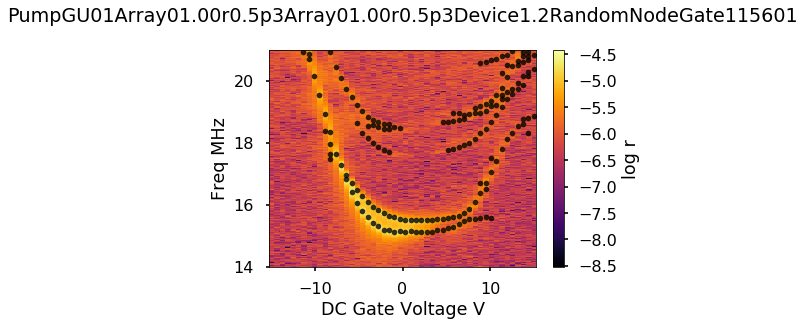

In [35]:
peakfreqsp3.plot(marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0, legend=False)
myheatmap(p.transpose(),'log r', cmap = 'inferno')
plt.title(file + '\n');


C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher

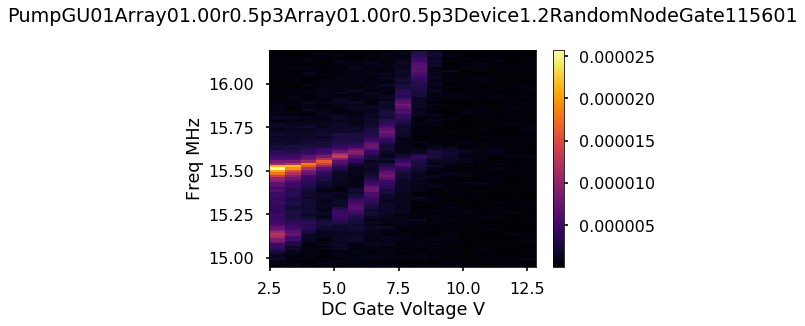

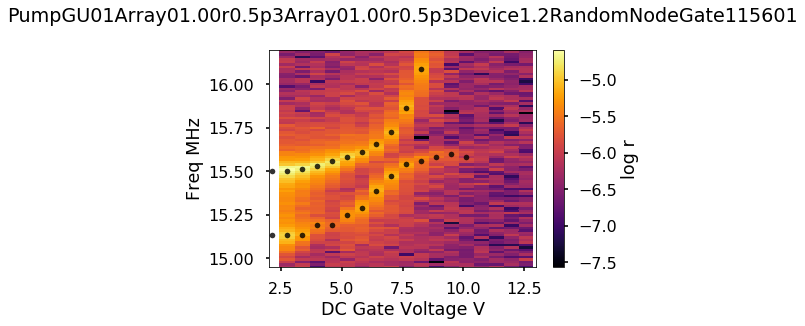

In [36]:
minvoltagep3 = 2.5
maxvoltagep3 = 13.1
lf = df['Freq MHz'] > 14.95 
hf = df['Freq MHz'] < 16.2
lv = df['DC Gate Voltage V'] > minvoltagep3
hv = df['DC Gate Voltage V'] < maxvoltagep3
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
nlog = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False)
myheatmap(n.transpose(), cmap = 'inferno')
plt.title(file + '\n');
plt.figure();
myheatmap(nlog.transpose(), 'log r', cmap = 'inferno')
ax = plt.gca()
peakfreqsp3.plot(marker='.', ax=ax, color='k', alpha=0.8, linestyle=None, linewidth=0, legend=False)
plt.xlim(2., 13.)
plt.ylim(14.95,16.2);
plt.title(file + '\n');


In [37]:
peakfreqsp3.head()

0          1          2          3          4  \
DC Gate Voltage V                                                          
14.99960           18.881764  20.382766  20.831663        NaN        NaN   
14.38773           18.334669  18.797595  20.158317  20.284569  20.663327   
13.77534           18.615230  18.755511  19.877756  20.158317  20.593186   
13.16336           18.545090  19.737475  19.919840  20.509018  20.635271   
12.55071           18.334669  19.569138  19.723447  20.466934  20.957916   

                           5          6  
DC Gate Voltage V                        
14.99960                 NaN        NaN  
14.38773           20.803607  20.943888  
13.77534           20.803607  20.943888  
13.16336                 NaN        NaN  
12.55071                 NaN        NaN

0          1
DC Gate Voltage V                      
9.489927           15.599198  16.496994
8.877310           15.585170  16.384770
8.265311           15.557114  16.090180
7.653050           15.543086  15.865731
7.041094           15.472946  15.725451
6.428456           15.388778  15.655311
5.816488           15.290581  15.613226
5.204131           15.248497  15.585170
4.592134           15.192385  15.557114
3.979494           15.192385  15.529058
3.367545           15.136273  15.515030

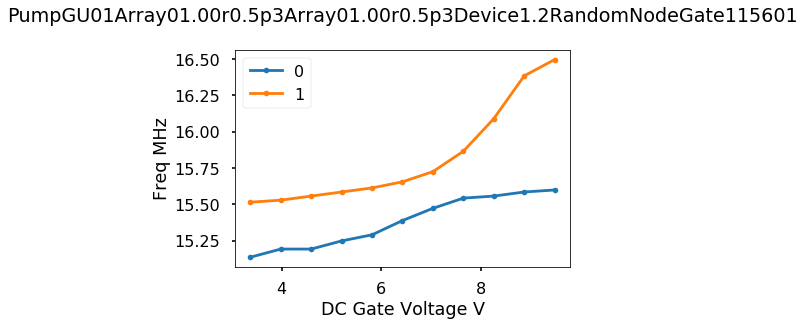

In [38]:
# Select the subset of the data for fitting.
peakfreqsp3fitset = ((peakfreqsp3[peakfreqsp3 < 17])[peakfreqsp3 > 15]).iloc[:,0:2].iloc[9:20]
# plot it.
peakfreqsp3fitset.plot(marker='.')
plt.ylabel('Freq MHz')
plt.title(file + '\n');
peakfreqsp3fitset

In [51]:
"""## Manually choose test parameters; these will be the starting points for the fit.
k1 = 30   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = .15    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = .15    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = 0.1;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.


#dk = frange(-1,1 , .1)
#dk = peakfreqsp.index.values
dk = frange(peakfreqsp3fitset.index.values.min(), peakfreqsp3fitset.index.values.max(), .001)
#dk = frange(-10, 1000, .001)


## Plot the guesses to find a good starting guess
peakfreqsp3fitset.plot( marker = '.', linestyle = 'None', legend=None)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,middle1(dk, m1,m2,k,k1), 'gray')


del m1,m2,k,k1,dk""";

array([16.49699399, 16.38476954, 16.09018036, 15.86573146, 15.7254509 ,
       15.65531062, 15.61322645, 15.58517034, 15.55711423, 15.52905812,
       15.51503006])

array([15.5991984 , 15.58517034, 15.55711423, 15.54308617, 15.47294589,
       15.38877756, 15.29058116, 15.24849699, 15.19238477, 15.19238477,
       15.13627255])

array([9.489927, 8.87731 , 8.265311, 7.65305 , 7.041094, 6.428456,
       5.816488, 5.204131, 4.592134, 3.979494, 3.367545])

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: numpy.arange


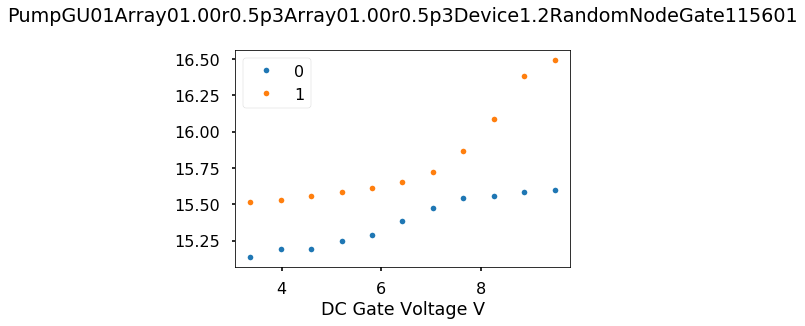

<Figure size 432x288 with 0 Axes>

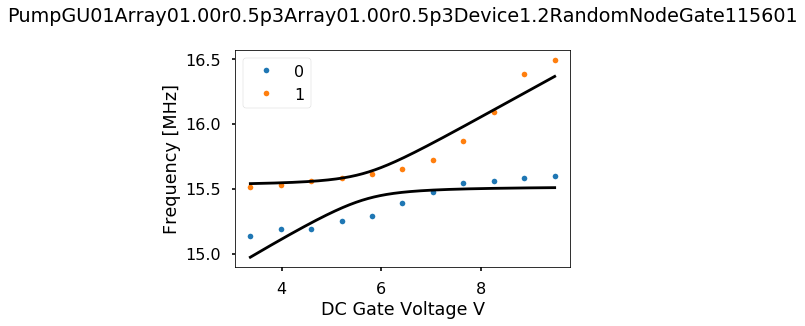

In [40]:
#upperantim = lmfit.Model(upperantifn)
#lowerantim = lmfit.Model(lowerantifn)

# input guesses for the fitting parameters
params2 = lmfit.Parameters()
params2.add('k1', value=30, vary=True)
params2.add('m1', value=.15, vary=True) 
params2.add('m2', value=.15 , vary=True)
params2.add('k', value=0.1, vary=True, min=0)

## plot the data
#ax = myheatmap((peakfreqsp3fitset).transpose(), cmap = 'gray') # cutting out last row because it is incomplete
peakfreqsp3fitset.plot( marker = '.',  linestyle= 'None', legend=True)
plt.title(file + '\n');

## data to be fit
dat1=peakfreqsp3fitset.iloc[:,1].values
dat2=peakfreqsp3fitset.iloc[:,0].values
x=peakfreqsp3fitset.index.values

display(dat1)
display(dat2)
display(x)

## perform the fit
out = lmfit.minimize(anticrossingresidual, params2, args=(x, dat1, dat2),nan_policy='propagate')
display(out) # display all the results

## Plot the fitting result.
dk = frange(peakfreqsp3fitset.index.values.min(), peakfreqsp3fitset.index.values.max(), .001)
# fit parameters
k1 = out.params['k1'].value   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = out.params['m1'].value    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = out.params['m2'].value    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = out.params['k'].value;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

## display the results
#display(out.params)


##  plot without heatmap
plt.figure();
peakfreqsp3fitset.plot( marker = '.', linestyle= 'None', legend=True)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')


#del m1,m2,k,k1,dk

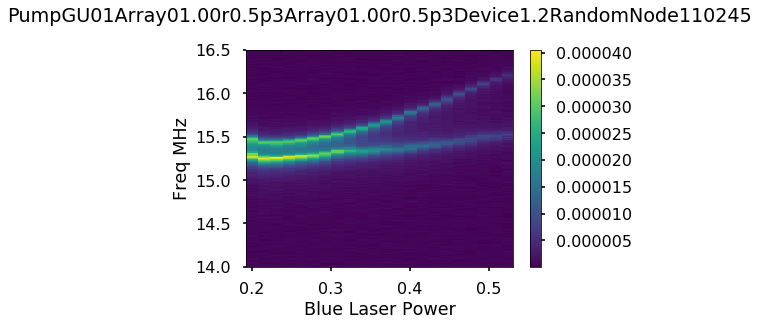

In [41]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNode110245'
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#df.head()

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['Blue Laser Power'] = df['DC Offset'].round(9)
p = df.pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
#p.columns_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 16)

myheatmap((p.iloc[:-1]).transpose())
plt.title(file + '\n');

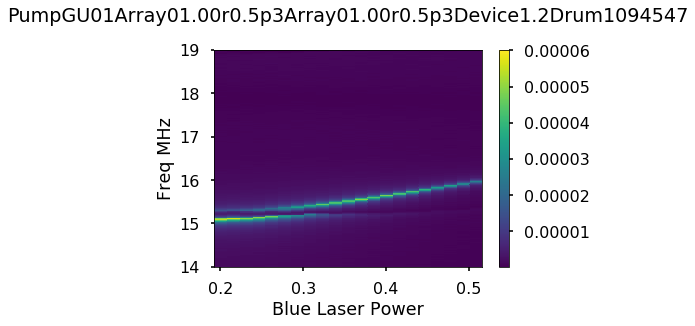

In [42]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1094547'
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

## warning: round(2) does not create evenly spaced frequency values.
df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['Blue Laser Power'] = df['DC Offset'].round(9)
p = df.pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap((p.iloc[:-1]).transpose()) # cutting out last laser power because it is incomplete
plt.title(file + '\n');

0


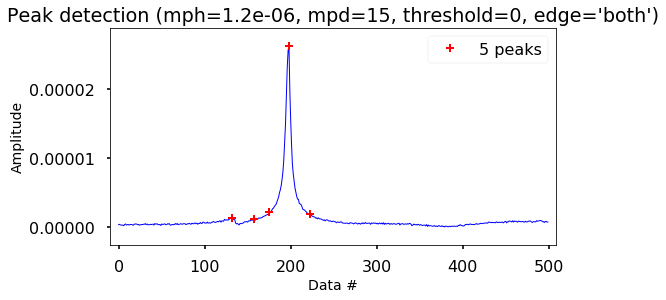

0.507692308
[132, 198]
1


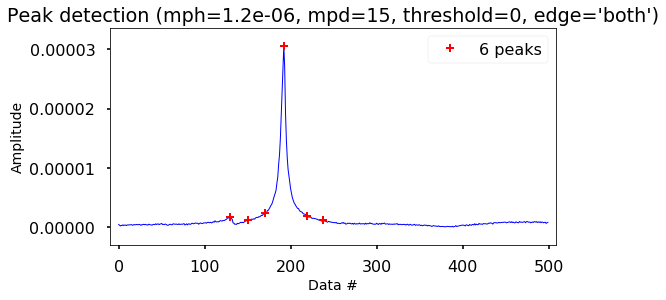

0.492307692
[130, 192]
2


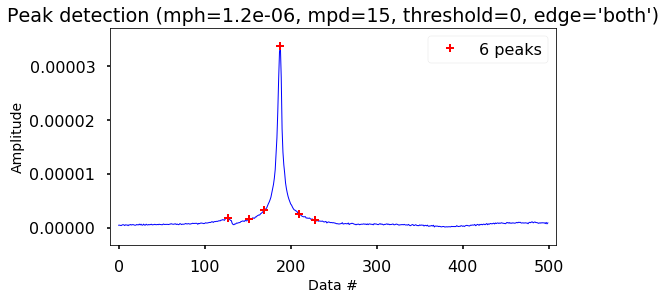

0.476923077
[127, 188]
3


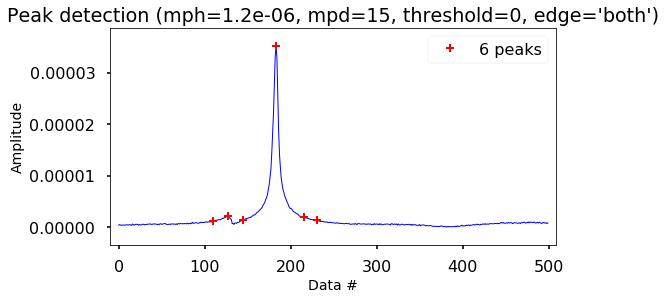

0.461538462
[127, 183]
4


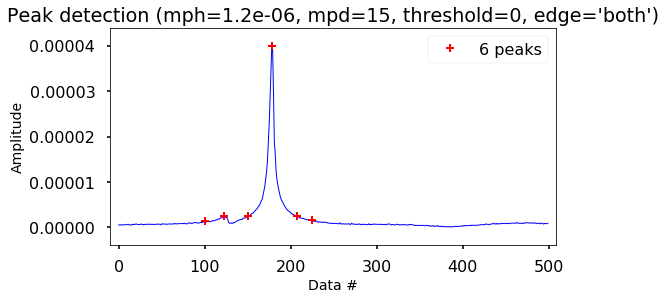

0.446153846
[123, 178]
5


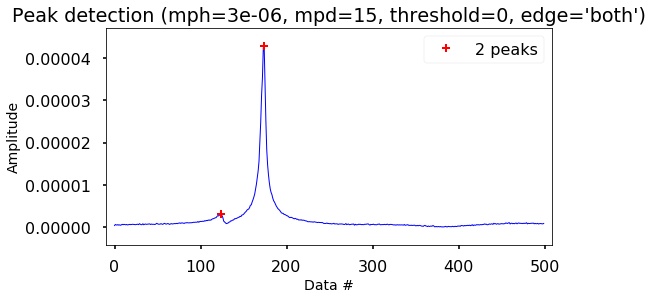

0.430769231
[124, 174]
6


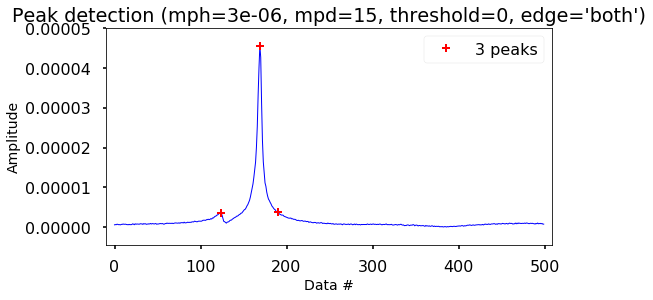

0.415384615
[124, 169]
7


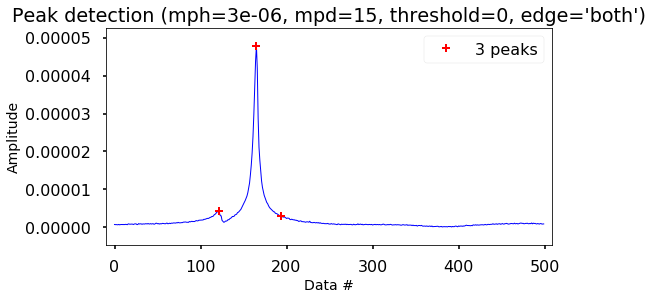

0.4
[121, 165]
8


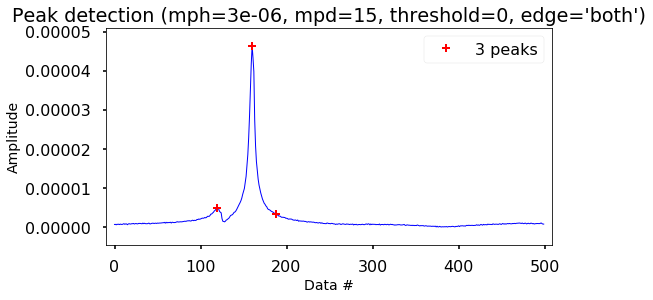

0.384615385
[119, 160]
9


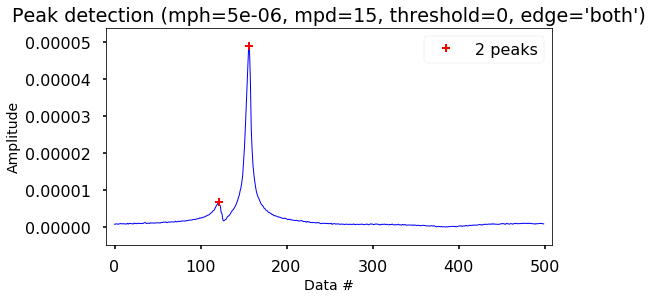

0.369230769
[121, 156]
10


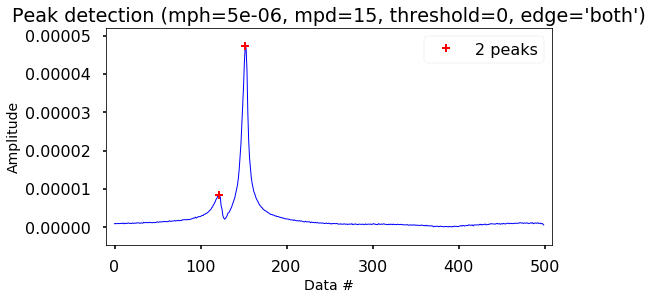

0.353846154
[121, 152]
11


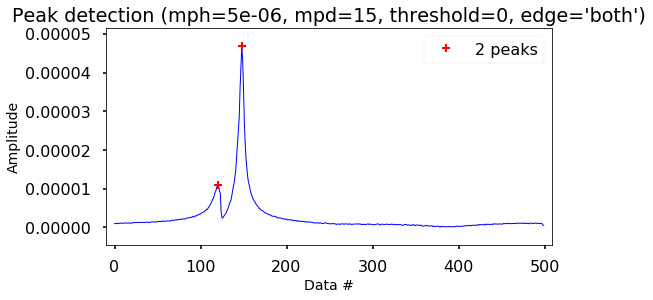

0.338461538
[120, 148]
12


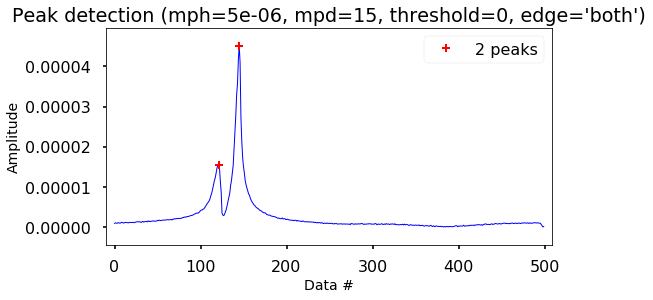

0.323076923
[121, 145]
13


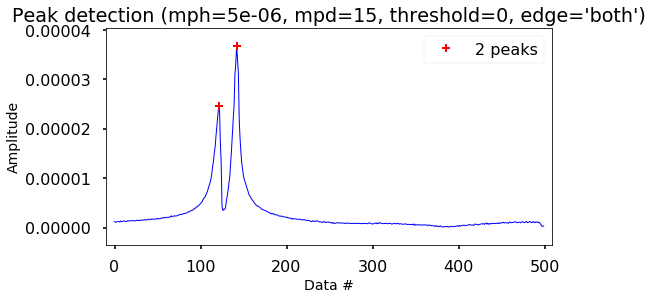

0.307692308
[122, 142]
14


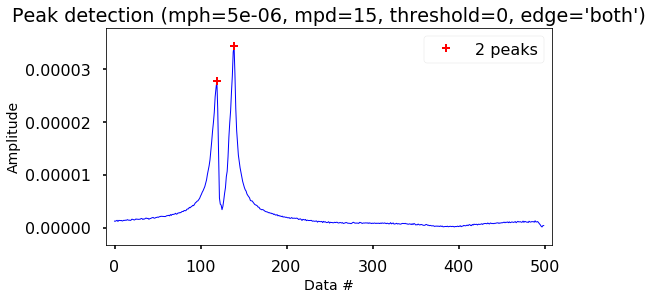

0.292307692
[119, 139]
15


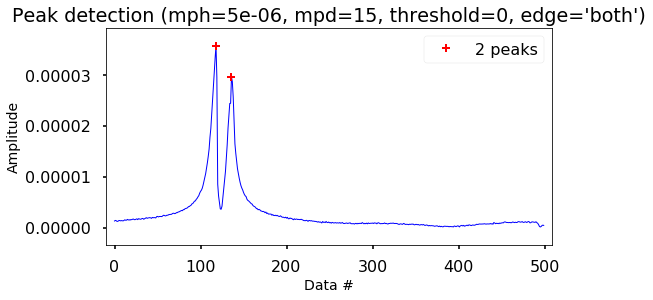

0.276923077
[118, 136]
16


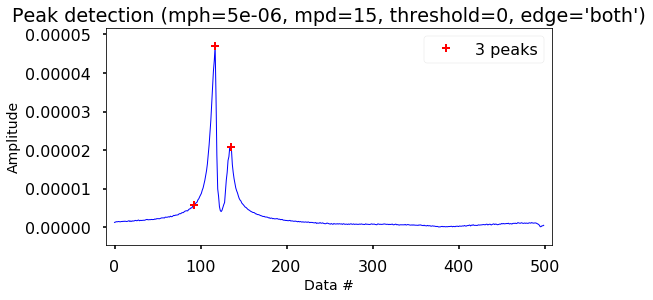

0.261538462
[117, 135]
17


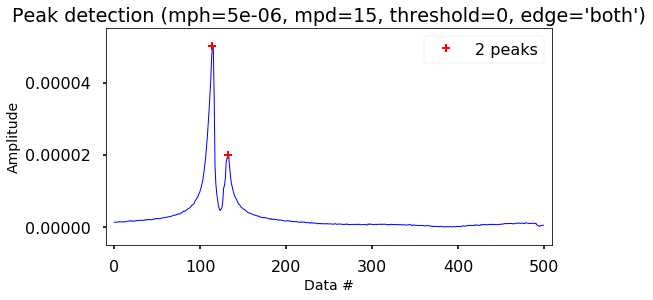

0.246153846
[114, 132]
18


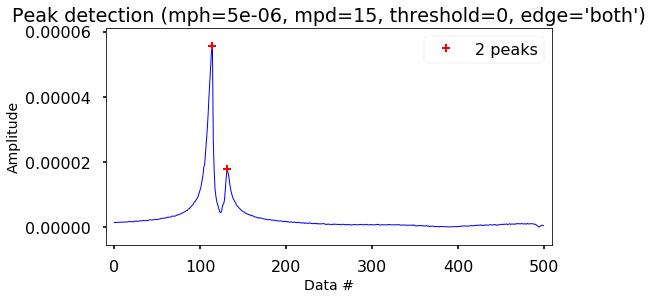

0.230769231
[114, 131]
19


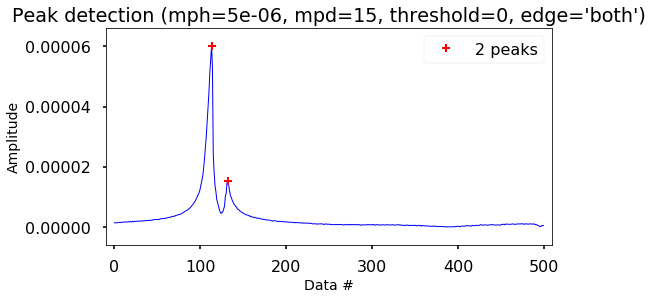

0.215384615
[113, 132]
20


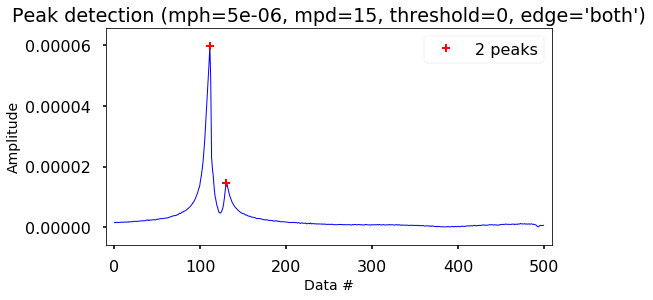

0.2
[111, 130]
21


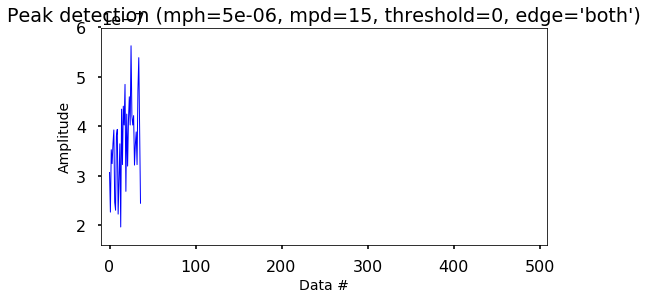

[Float64Index([15.322645291, 15.983967936], dtype='float64', name='Freq MHz'), Float64Index([15.30260521, 15.923847695], dtype='float64', name='Freq MHz'), Float64Index([15.27254509, 15.883767535], dtype='float64', name='Freq MHz'), Float64Index([15.27254509, 15.833667335], dtype='float64', name='Freq MHz'), Float64Index([15.23246493, 15.783567134], dtype='float64', name='Freq MHz'), Float64Index([15.24248497, 15.743486974], dtype='float64', name='Freq MHz'), Float64Index([15.24248497, 15.693386774], dtype='float64', name='Freq MHz'), Float64Index([15.21242485, 15.653306613], dtype='float64', name='Freq MHz'), Float64Index([15.19238477, 15.603206413], dtype='float64', name='Freq MHz'), Float64Index([15.21242485, 15.563126253], dtype='float64', name='Freq MHz'), Float64Index([15.21242485, 15.523046092], dtype='float64', name='Freq MHz'), Float64Index([15.20240481, 15.482965932], dtype='float64', name='Freq MHz'), Float64Index([15.21242485, 15.452905812], dtype='float64', name='Freq MHz'

peak1 freq [MHz]  peak2 freq [MHz]
Blue Laser Power                                    
0.507692                 15.322645         15.983968
0.492308                 15.302605         15.923848
0.476923                 15.272545         15.883768
0.461538                 15.272545         15.833667
0.446154                 15.232465         15.783567
0.430769                 15.242485         15.743487
0.415385                 15.242485         15.693387
0.400000                 15.212425         15.653307
0.384615                 15.192385         15.603206
0.369231                 15.212425         15.563126
0.353846                 15.212425         15.523046
0.338462                 15.202405         15.482966
0.323077                 15.212425         15.452906
0.307692                 15.222445         15.422846
0.292308                 15.192385         15.392786
0.276923                 15.182365         15.362725
0.261538                 15.172345         15.352705
0.246154                 15.142285         15.322645
0.230769                 15.142285         15.312625
0.215385                 15.132265         15.322645
0.200000                 15.112224         15.302605

In [43]:
freqlistp = []
peaksintp = []


## I tweaked this a lot for this particular dataset
for i in range(len(p)):
    print(i)
    if i < 5:
        mph = 1.2e-6
    elif i < 9:
        mph = 3e-6
    else: 
        mph = 5e-6
    res= detect_peaks(p.iloc[i], 
             mph=mph, 
           #  threshold=1e-8,
             mpd=15,
             edge = 'both',
             show=True)
 
    ## I manually picked out the correct peaks
    if i <= 2:
        res = list(res[j] for j in [0,3])
    elif i <= 4:
        res = list(res[j] for j in [1,3] )
    elif i == 16:
        res = list(res[j] for j in [1,2])
    elif i ==21:
        continue
    else:
        res = list(res[j] for j in [0,1])
        
    print(p.iloc[i].name)
    print(res)
    freqlistp.append(p.columns[res])
    peaksintp.append(res)
    #print(peaksintp[i])
    
print(freqlistp)
print(peaksintp)

peakfreqsp = pd.DataFrame(freqlistp, index = p.index[:-1], columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqsp

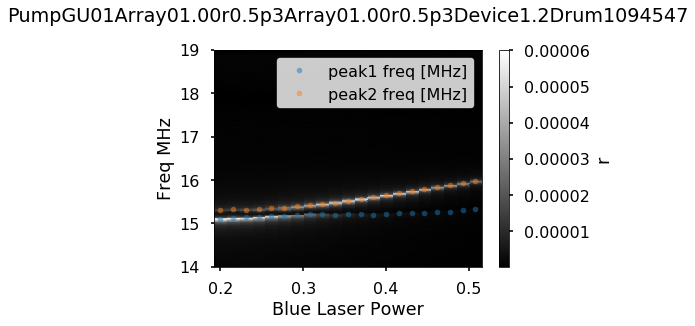

In [44]:
ax = myheatmap((p.iloc[:-1]).transpose(), 'r', cmap = 'gray') # cutting out last row because it is incomplete
peakfreqsp.plot(ax=ax,  marker = '.', alpha = .5, linestyle= 'None', legend=True)

plt.title(file + '\n');

In [45]:
"""
## Manually choose test parameters; these will be the starting points for the fit.
k1 = 1.3   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = .0057    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = .007    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = 0.01;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.


#dk = frange(-1,1 , .1)
#dk = peakfreqsp.index.values
dk = frange(peakfreqsp.index.values.min(), peakfreqsp.index.values.max(), .001)
#dk = frange(-10, 1000, .001)


## Plot the guesses to find a good starting guess
peakfreqsp.plot( marker = '.', linestyle = 'None', legend=None)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1))
plt.plot(dk,upperantifn(dk, m1,m2,k,k1))
plt.plot(dk,middle1(dk, m1,m2,k,k1))


del m1,m2,k,k1,dk
""";

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: numpy.arange


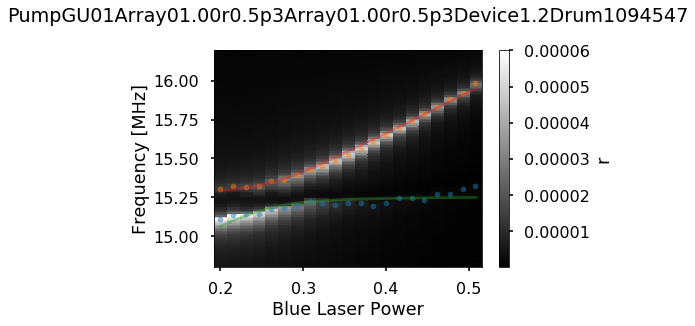

<Figure size 432x288 with 0 Axes>

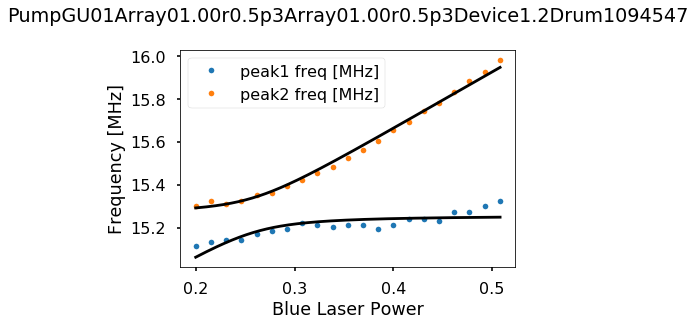

In [46]:
#upperantim = lmfit.Model(upperantifn)
#lowerantim = lmfit.Model(lowerantifn)

# input guesses for the fitting parameters
params1 = lmfit.Parameters()
params1.add('k1', value=1.3, vary=True)
params1.add('m1', value=.0057, vary=True) # should maybe have max 1, but seems to work better without.
params1.add('m2', value=.007 , vary=True)
params1.add('k', value=0.01, vary=True)

## plot the data
ax = myheatmap((p.iloc[:-1]).transpose(), 'r',cmap = 'gray') # cutting out last row because it is incomplete
peakfreqsp.plot(ax=ax, marker = '.', alpha = .5, linestyle= 'None', legend=False)
plt.title(file + '\n');

## data to be fit
dat1=peakfreqsp.iloc[:,1].values
dat2=peakfreqsp.iloc[:,0].values
x=peakfreqsp.index.values

## perform the fit
out = lmfit.minimize(anticrossingresidual, params1, args=(x, dat1, dat2))
display(out) # display all the results

## Plot the fitting result.
dk = frange(peakfreqsp.index.values.min(), peakfreqsp.index.values.max(), .001)
# test parameters
k1 = out.params['k1'].value   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = out.params['m1'].value    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = out.params['m2'].value    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = out.params['k'].value;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

## display the results
#display(out.params)

#peakfreqsp.plot( marker = '.', linestyle = 'None', legend=None)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), alpha=.4)
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), alpha=.4)
plt.ylim(ymin=14.8,ymax=16.2)
#plt.plot(dk,middle1(dk, m1,m2,k,k1))

## second plot without heatmap
plt.figure();
peakfreqsp.plot( marker = '.', linestyle= 'None', legend=True)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')


#del m1,m2,k,k1,dk

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


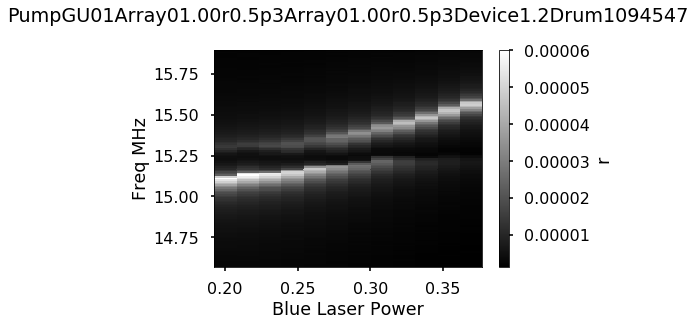

In [47]:
lf = df['Freq MHz'] > 14.57 
hf = df['Freq MHz'] < 15.9 
lv = df['Blue Laser Power'] > 0.1
hv = df['Blue Laser Power'] < 0.38
n = df[lf][hf][lv][hv].pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
myheatmap(n.transpose(), cmap = 'gray', colorbarlabel='r')
plt.title(file + '\n');

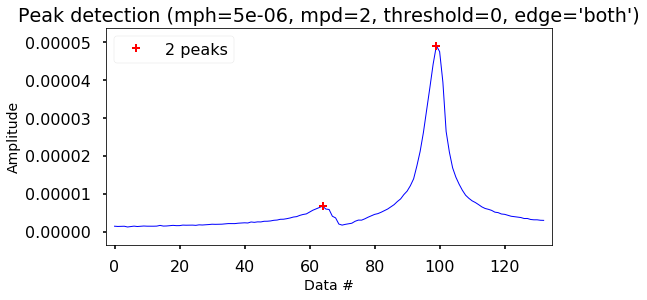

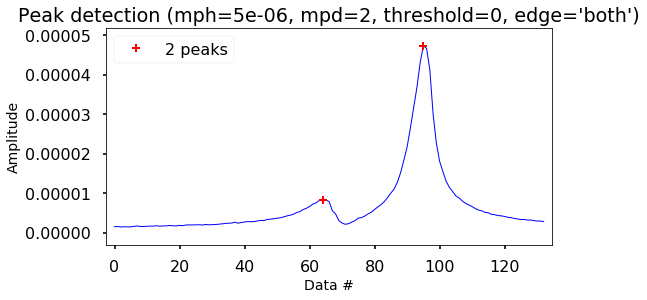

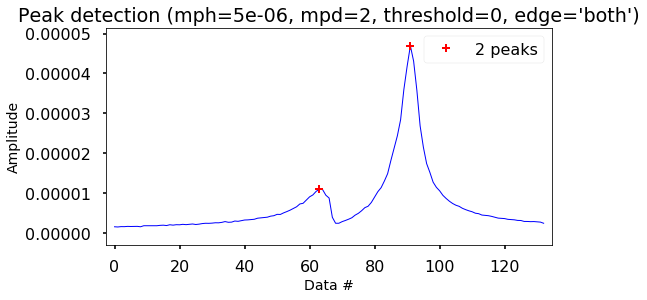

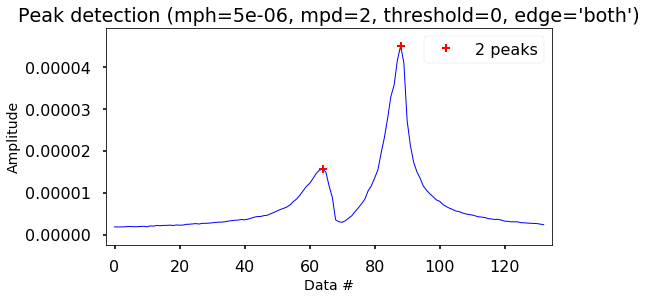

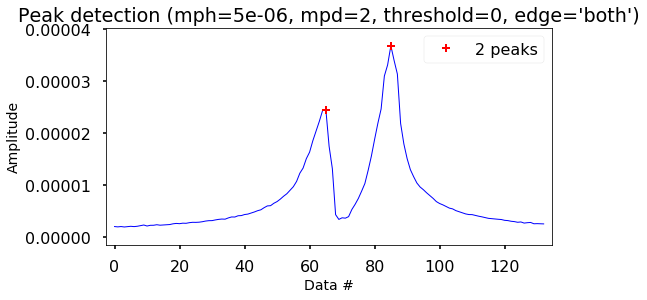

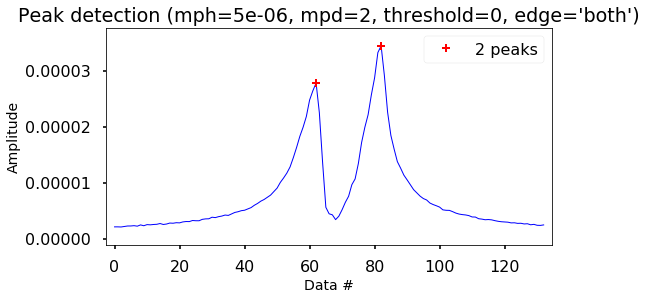

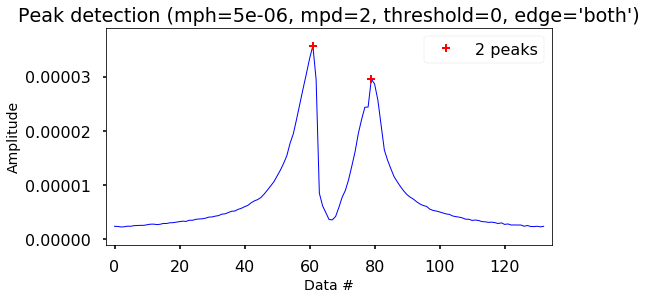

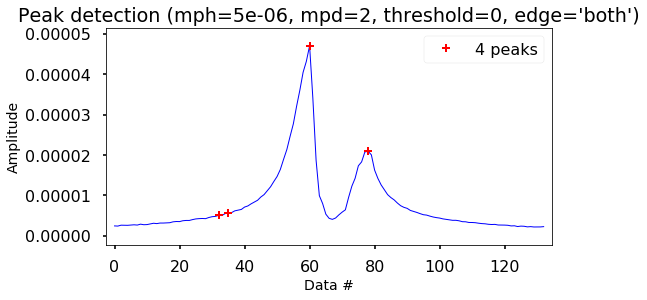

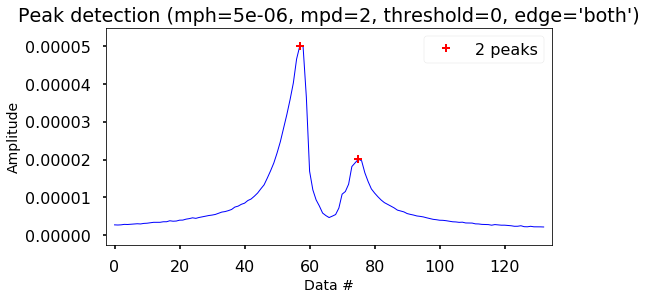

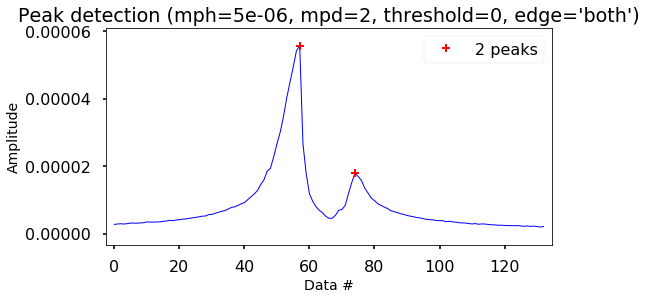

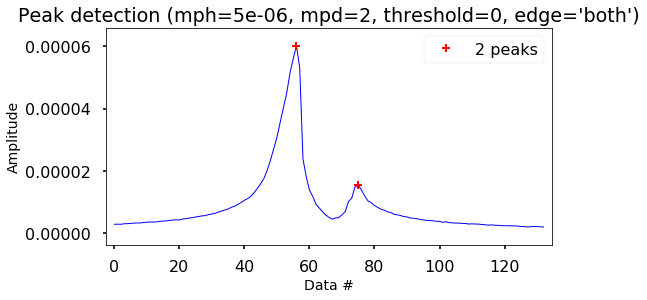

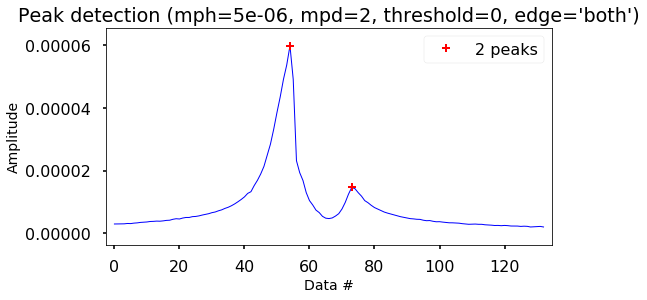

peak1 freq [MHz]  peak2 freq [MHz]
Blue Laser Power                                    
0.369231                 15.212425         15.563126
0.353846                 15.212425         15.523046
0.338462                 15.202405         15.482966
0.323077                 15.212425         15.452906
0.307692                 15.222445         15.422846
0.292308                 15.192385         15.392786
0.276923                 15.182365         15.362725
0.261538                 15.172345         15.352705
0.246154                 15.142285         15.322645
0.230769                 15.142285         15.312625
0.215385                 15.132265         15.322645
0.200000                 15.112224         15.302605

In [48]:

# initialize peaks list
peaksint = []
freqlist = []

for i in range(len(n)):
    res = detect_peaks(n.iloc[i], 
             mph=5e-6, 
           #  threshold=1e-8,
             mpd=2,
             edge = 'both',
             show=True)
    #print(res)
    freqlist.append(n.columns[res[-2:]])
    # shorten results to just 2 peaks
    peaksint.append(res[-2:])
    #print(peaksint[i])
    
#display(peaksint)

peakfreqsn = pd.DataFrame(freqlist, index = n.index, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqsn


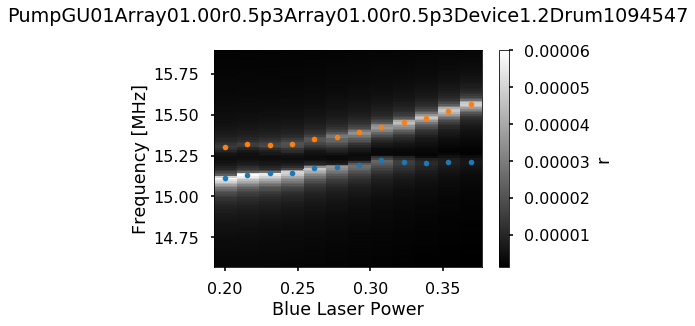

In [49]:
# To change the colors in the pcolormesh, add the pcolormesh argument: cmap = cmap
#cmap = sns.cubehelix_palette(n_colors = 1, start=0, rot=1, light=1, as_cmap=True)
#cmap = sns.cubehelix_palette( light=1, as_cmap=True)
#cmap = sns.color_palette("Grey", as_cmap=True)

ax = myheatmap(n.transpose(), 'r', cmap='gray')
peakfreqsn.plot(ax=ax, marker = '.', linestyle='None', legend=False)
plt.ylabel("Frequency [MHz]");
plt.title(file + '\n');

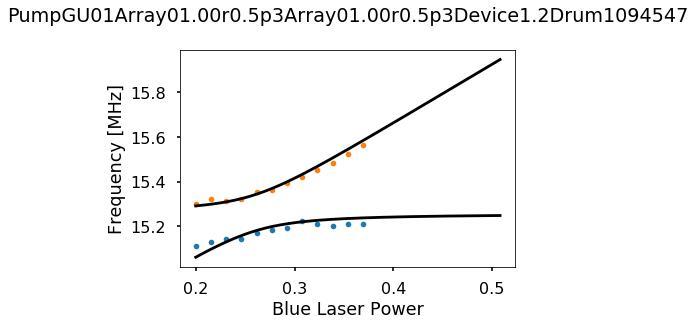

In [50]:
peakfreqsn.plot(marker = '.', linestyle='None', legend=False)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n');

## I didn't re-fit to this specific data; I already fit to the larger dataset.
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')